## Overview

Ammunition manufactures provide a wealth of data for their cartridges. These data allow shooters to determine how 'flat' the trajectory of the rounds are and make adjustments for the drop and slow down of bullets at long range.

In this assignment we will use manufacturer's data and see how well we can match observations to the output of a computational model. Scientists and engineers have been creating so-called *ballistics models* since the turn of the last century. Such models allow for:

* the anticipation of the long range trajectory of projectiles, 
*  answering 'what if' questions like what would be the the result of a lower drag bullet vs. a cartridge with more powder (hence, highervelocity), and 
* provide sophisticated interpolation between observations. 

In this class we will implement a pair of famous models for ballistics - the G1 and G7 models. Results of these models will be compared to the data from manufactures. 

Such an assignment has some interesting aspects for both code development and modeling. Conceptually, the exercise is just like figuring out the best angle to throw a football, how fast to toss a bean bag in corn hole, or determine where a re-entry vehicle from the space station will touch down. Here, we use bullets because the amount of easily found data that is available. The objectives of the lesson are to:

* gain an understanding of two dimensional motion, the ODEs that arise, and how they are solved.
* create modules for both data storage/retrieval and dynamical modeling.
* do a simple optimization.
* relate results in a tabular form.

### Two dimensional motion and solving ODEs

Until today, the ODEs we solved had only one dimension. For success with a projectile, we will need two dimensions. $x$ will be used to represent the range of the projectile - how far it travel over a flat Earth. The $y$ axis will represent the vertical drop in the projectile as it moves down range. 

Let us suppose that we now have some vector drag force, $\mathbf{F_d}$. Now, the equations of motion would be

$$\mathbf{F} = m \mathbf{a} = m\mathbf{g} - \mathbf{F_d}$$

where we note that all quantities in **boldface** are vectors. That means that it's possible to write equations for $x$ and $y$ separately. This more explicit form is closer to implementation in Python and those equations are

$$ a_x = ~~- \mathbf{F_d}/m  \cdot \mathbf{\hat x}$$
$$ a_y = g - \mathbf{F_d}/m  \cdot \mathbf{\hat y}$$

Where $\mathbf{\hat x}$ is the unit vector in the $x$ direction and likewise for $\mathbf{\hat y}$. The mass has been divided through the equations. These equations indicate that the drag force must be projected onto each of the two cardinal axes, that's what the $\cdot$ or dot product accomplishes. We will return to this later. 

Lets conclude with a clear statement about what we require of the ODE solver. The $\mathbf{y_o}$ will be the initial state and consist of $(x^o,y^o,v^o_x,v^o_y)$; the 2 initial positions and 2 initial velocities. The function you write to pass to the ODE solver will return $(v_x^1,v_y^1,a_x^1,a_y^1)$; the 2 velocities and the 2 accelerations at time $t_1$, then given $t_1$, $t_2$ will be returned and so on.

### In-class
Write the ODE function that does specifies the above drag equations in 2D. Assume that an object, instead of a parameter is passed to the function. This object includes a function `get_drag` that will accept a value $|\mathbf{v}|$ and return the magnitude of the drag force. Also assume $g$, the gravitational acceleration is local in scope and accessed through `b.g`, and `get_drage` is accessed through `b.get_drag`.

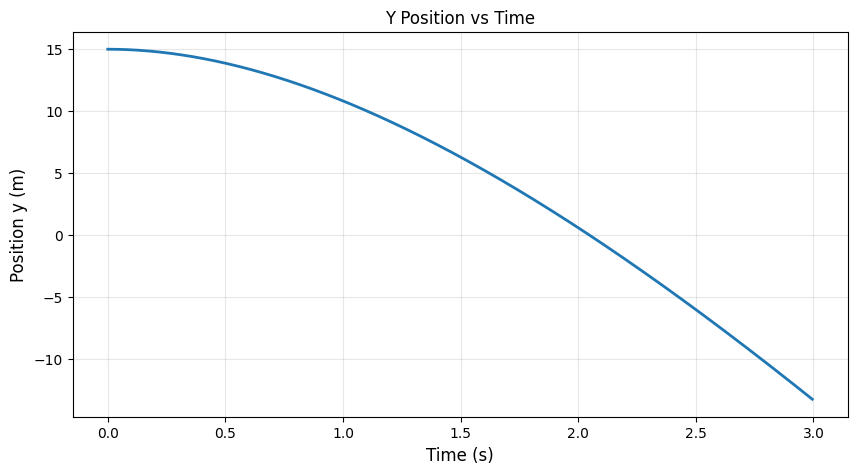

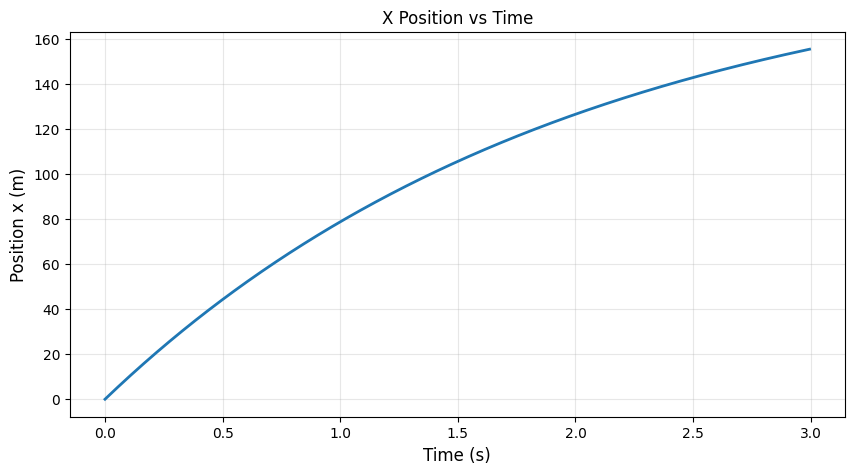

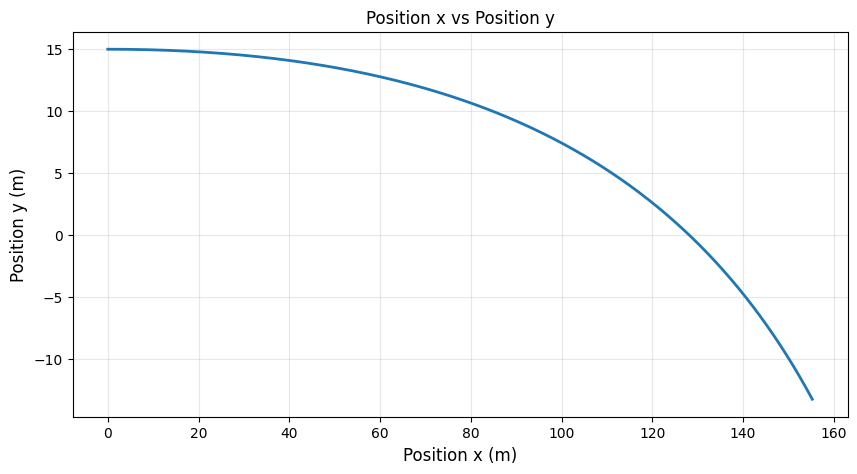

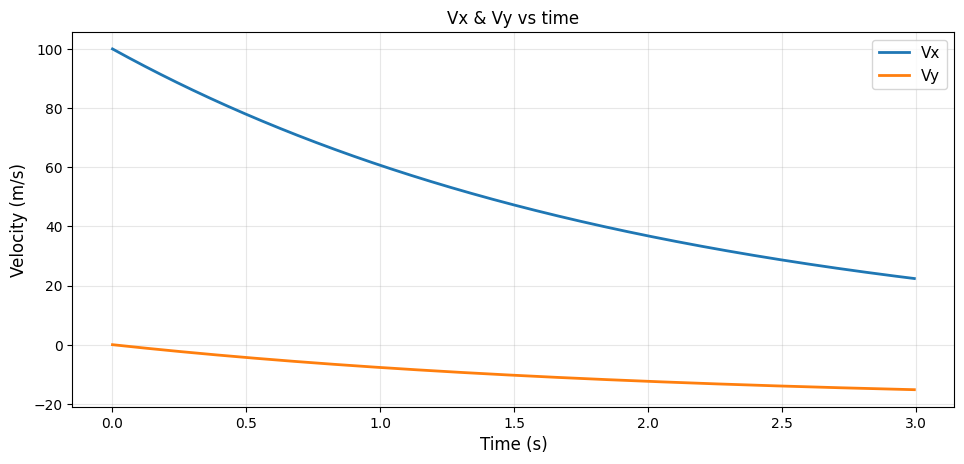

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import funcs
importlib.reload(funcs)

from scipy.interpolate import interp1d

class bullet:
    def __init__(self, g=9.8):
        self.g = g
    
    def get_drag(self, v):
        return .5*v

def projectile(t, y, b):
    """
    To be given to an ODE integrator to find the trajectory of a bullet.
    given y, returns dydt
    b is an object assumed to contain:
        b.g - graviational acceleration
        b.drag - a function that returns the drag force Fd, given the magnitude of velocity.
    """
    #Unpack y
    x0, y0, vx, vy = y
    
    #Get magnitude of velocity
    v_mag = np.sqrt(vx**2 + vy**2)

    if v_mag == 0:
        return np.array([0, 0, 0, -b.g])

    #Get drag force
    F_drag = b.get_drag(v_mag)
    
    #calculate components of acceleration
    ax = -F_drag * (vx/v_mag)
    ay = -F_drag * (vy/v_mag) - b.g
    
    return np.array([vx, vy, ax, ay])

             
bul = bullet(9.8)
y0 = np.array([0,15,100,0])

y,t = funcs.solve_ode(projectile,[0,3],y0,funcs.EulerRichardson,bul,first_step=0.005)


# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y[:,1], linewidth=2)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position y (m)', fontsize=12)
plt.title('Y Position vs Time', fontsize=12)
plt.grid(True, alpha=0.3)

plt.figure(figsize=(10, 5))
plt.plot(t, y[:,0], linewidth=2)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position x (m)', fontsize=12)
plt.title('X Position vs Time', fontsize=12)
plt.grid(True, alpha=0.3)

plt.figure(figsize=(10, 5))
plt.plot(y[:,0], y[:,1], linewidth=2)
plt.xlabel('Position x (m)', fontsize=12)
plt.ylabel('Position y (m)', fontsize=12)
plt.title('Position x vs Position y', fontsize=12)
plt.grid(True, alpha=0.3)

plt.figure(figsize=(10, 5))
plt.plot(t, y[:,2], linewidth=2, label="Vx")
plt.plot(t, y[:,3], linewidth=2, label="Vy")
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Velocity (m/s)', fontsize=12)
plt.title('Vx & Vy vs time', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)


plt.tight_layout(pad=2.0)
plt.show()

## The drag force
The drag force will be significant in determining the projectile's path. We begin with the following commonly used expression for drag force

$$\mathbf{F}_d= -{1 \over 2} \rho v^2 A C_d \mathbf{\hat v}$$

$C_d$ is the non-dimensional drag coefficient, $\rho$ is the density of the air the projectile travels through [Wikipedia:Density of Air](https://en.wikipedia.org/wiki/Density_of_air), $|v|$ is the magnitude of velocity, and $\mathbf{\hat v} = \frac{\mathbf{v}}{|\mathbf{v}|}$ the normalized velocity direction. Mass, if you are wondering, is drawn into $C_d$.

### The ballistic coefficient
Using the basic equation for drag force presents a problem. How will we determine $C_d$ for each of the many different bullets that are available? Further, we expect $C_d$ to be a function of the speed of the projectile, $C_d(v)$. This is too much measurement and too much fitting. Instead, consider the following strategy.

$S_d = \frac{m}{A}$ is the [Wikipedia:Sectional density](https://en.wikipedia.org/wiki/Sectional_density) of the projectile. It is the mass $m$ divided by the cross-sectional area $A$ of the bullet.

The form factor of a bullet is $f=\frac{C_d}{C^{\mathbf{G}}_{d}}$, where $C_d$ is the bullet's coefficient of drag, and $C^{\mathbf{G}}_{d}$ is the drag of a reference round. Here, we learn that $C_d$ isn't known, but that the calculation is done with respect to a round it is known for, called a *reference model*. That's the so-called G model, which is no more than a set of measurements for a single, reference projectile. We will see that this ratio produces nice simplifications in the drag equation.

The **ballistic coefficient** is then the amount a bullet slows down in flight relative to a reference round. Based on the previous relations, this is expressed as

$$b_c = \frac{S_d}{f}$$

This is the number provided by the manufactures to tell shooters how well the bullet travels through the air. A value of 1.0 means the bullet has the same drag as the reference round. A value of greater than one would indicate the bullet experiences less drag than the reference round. A value less than one indicates the bullet experiences more drag than the reference round. Note that because of the dependence on $C^{\mathbf{G}}_{d}$ the ballistic coefficient is always with respect to some reference. Most manufactures report ballistic coefficients for G1 reference bullets only and use imperial units of measure. This has a tendency to make the value higher, which shooters like. The same value expressed for the (usually superior) G7 model is lower. So even if the model is better, the lower number turns off shooters that what to think bigger is better, so G1 remains, even if it was formulated in 1881 and involves a one pound projectile!

**Note the units of the ballistic coefficient.** They are pounds per inch squared in imperial units, and most manufactures report them in imperial units. To get to metric, you must convert to kilograms per meter squared.

In conclusion, to model the trajectory of a round, one uses published data on a reference round, and then computes how much the trajectory changes for a particular round. The difference between the reference round and the round in question is expressed as the inverse of the ballistic coefficient, $b_c$. A value of $b_c$ less than one indicates the round is impacted more by air resistance than the reference round. A value of $b_c$ greater than one indicates the projectile experiences less air resistance than the reference round.

### Final form of drag force

***Students do this in class***
To complete the analysis, multiply the right hand side of the original drag relation by one in the form of $\frac{b_c}{b_c}$. Write out the expression for $b_c$ based on the above discussion of sectional density and form factor. Replace the $b_c$ in the numerator with that. Achieve some cancelations and substitutions. Divide through by mass to give acceleration instead of force. Generalize $C_d$ to $C_d(m)$, where $m$ is the Mach number of the projectile,

$$m = \frac{|\mathbf{v}|}{v_s}$$

Here, $v_s$ is the speed of sound in air, see here for tables: [Wikipedia: Density of Air](https://en.wikipedia.org/wiki/Density_of_air).

***Check answer***

As a result, any round's trajectory is expressed as a reference round's trajectory scaled by the ballistic coefficient of the particular round. This gives the following friction relation

$$\mathbf{a_d} = -\frac{1}{2b_c} \rho C_d^G(m) |v|^2\mathbf{\hat v}$$

Partitioning the force into ''x'' and ''y'' components based on the $\mathbf{\hat v}$, the equations of motion for the bullet take the following form

$$a_x = ~~ - \frac{1}{2b_c}C_d^G(m) v^{2}\frac{v_x}{|\mathbf{v}|}$$

$$a_y = -g - \frac{1}{2b_c}C_d^G(m) v^{2}\frac{v_y}{|\mathbf{v}|}$$

***In class***
Write a function that returns the magnitude of the drag function. Assume you have access to the other parts of the calculation, such as helper functions to convert units, a variable that sets the units, and whatever constants are needed.

### Difference in models
We will use both the G1 on G7 models, but what's the difference? It has to do with the projectile the data is taken on. The 'standard' projectiles of G1 and G7 are different.

![G1 vs. G7 standard projectiles](Gmodels.png)

Above, you can see the G7 model is based on a more modern, low drag bullet that has a 'boat tail' end and longer nose. The G1 is an older type of round that's mostly historical in terms of shape. It also weighed a full pound!

A rule of thumb here might be that the more the model looks like the bullet you use, the better you'll do.

### Tables of Data
The data is tabulated in the form of Mach number $m$ in the first column and $K_d$ in the second. $K_d$, what's that? Well it's an older way of relating the data. You'll need to apply the correction that

$$C_d = \frac{\pi}{4} K_d$$

to bring the values in the tables into agreement with the drag model we develop.

Data are from [here](https://www.jbmballistics.com/ballistics/downloads/downloads.shtml)

The relations are explored in a graph below.

#### G1 Model
`np.array([[0.00, 0.2629],\
                    [0.05, 0.2558],\
                    [0.10, 0.2487],\
                    [0.15, 0.2413],\
                    [0.20, 0.2344],\
                    [0.25, 0.2278],\
                    [0.30, 0.2214],\
                    [0.35, 0.2155],\
                    [0.40, 0.2104],\
                    [0.45, 0.2061],\
                    [0.50, 0.2032],\
                    [0.55, 0.2020],\
                    [0.60, 0.2034],\
                    [0.70, 0.2165],\
                    [0.725, 0.2230],\
                    [0.75, 0.2313],\
                    [0.775, 0.2417],\
                    [0.80, 0.2546],\
                    [0.825, 0.2706],\
                    [0.85, 0.2901],\
                    [0.875, 0.3136],\
                    [0.90, 0.3415],\
                    [0.925, 0.3734],\
                    [0.95, 0.4084],\
                    [0.975, 0.4448],\
                    [1.0, 0.4805],\
                    [1.025, 0.5136],\
                    [1.05, 0.5427],\
                    [1.075, 0.5677],\
                    [1.10, 0.5883],\
                    [1.125, 0.6053],\
                    [1.15, 0.6191],\
                    [1.20, 0.6393],\
                    [1.25, 0.6518],\
                    [1.30, 0.6589],\
                    [1.35, 0.6621],\
                    [1.40, 0.6625],\
                    [1.45, 0.6607],\
                    [1.50, 0.6573],\
                    [1.55, 0.6528],\
                    [1.60, 0.6474],\
                    [1.65, 0.6413],\
                    [1.70, 0.6347],\
                    [1.75, 0.6280],\
                    [1.80, 0.6210],\
                    [1.85, 0.6141],\
                    [1.90, 0.6072],\
                    [1.95, 0.6003],\
                    [2.00, 0.5934],\
                    [2.05, 0.5867],\
                    [2.10, 0.5804],\
                    [2.15, 0.5743],\
                    [2.20, 0.5685],\
                    [2.25, 0.5630],\
                    [2.30, 0.5577],\
                    [2.35, 0.5527],\
                    [2.40, 0.5481],\
                    [2.45, 0.5438],\
                    [2.50, 0.5397],\
                    [2.60, 0.5325],\
                    [2.70, 0.5264],\
                    [2.80, 0.5211],\
                    [2.90, 0.5168],\
                    [3.00, 0.5133],\
                    [3.10, 0.5105],\
                    [3.20, 0.5084],\
                    [3.30, 0.5067],\
                    [3.40, 0.5054],\
                    [3.50, 0.5040],\
                    [3.60, 0.5030],\
                    [3.70, 0.5022],\
                    [3.80, 0.5016],\
                    [3.90, 0.5010],\
                    [4.00, 0.5006],\
                    [4.20, 0.4998],\
                    [4.40, 0.4995],\
                    [4.60, 0.4992],\
                    [4.80, 0.4990],\
                    [5.00, 0.4988]])`

#### G7 Model

`array([[0.00, 0.1198],\
                    [0.05, 0.1197],\
                    [0.10, 0.1196],\
                    [0.15, 0.1194],\
                    [0.20, 0.1193],\
                    [0.25, 0.1194],\
                    [0.30, 0.1194],\
                    [0.35, 0.1194],\
                    [0.40, 0.1193],\
                    [0.45, 0.1193],\
                    [0.50, 0.1194],\
                    [0.55, 0.1193],\
                    [0.60, 0.1194],\
                    [0.65, 0.1197],\
                    [0.70, 0.1202],\
                    [0.725, 0.1207],\
                    [0.75, 0.1215],\
                    [0.775, 0.1226],\
                    [0.80, 0.1242],\
                    [0.825, 0.1266],\
                    [0.85, 0.1306],\
                    [0.875, 0.1368],\
                    [0.90, 0.1464],\
                    [0.925, 0.1660],\
                    [0.95, 0.2054],\
                    [0.975, 0.2993],\
                    [1.0, 0.3803],\
                    [1.025, 0.4015],\
                    [1.05, 0.4043],\
                    [1.075, 0.4034],\
                    [1.10, 0.4014],\
                    [1.125, 0.3987],\
                    [1.15, 0.3955],\
                    [1.20, 0.3884],\
                    [1.25, 0.3810],\
                    [1.30, 0.3732],\
                    [1.35, 0.3657],\
                    [1.40, 0.3580],\
                    [1.50, 0.3440],\
                    [1.55, 0.3376],\
                    [1.60, 0.3315],\
                    [1.65, 0.3260],\
                    [1.70, 0.3209],\
                    [1.75, 0.3160],\
                    [1.80, 0.3117],\
                    [1.85, 0.3078],\
                    [1.90, 0.3042],\
                    [1.95, 0.3010],\
                    [2.00, 0.2980],\
                    [2.05, 0.2951],\
                    [2.10, 0.2922],\
                    [2.15, 0.2892],\
                    [2.20, 0.2864],\
                    [2.25, 0.2835],\
                    [2.30, 0.2807],\
                    [2.35, 0.2779],\
                    [2.40, 0.2752],\
                    [2.45, 0.2725],\
                    [2.50, 0.2697],\
                    [2.55, 0.2670],\
                    [2.60, 0.2643],\
                    [2.65, 0.2615],\
                    [2.70, 0.2588],\
                    [2.75, 0.2561],\
                    [2.80, 0.2533],\
                    [2.85, 0.2506],\
                    [2.90, 0.2479],\
                    [2.95, 0.2451],\
                    [3.00, 0.2424],\
                    [3.10, 0.2368],\
                    [3.20, 0.2313],\
                    [3.30, 0.2258],\
                    [3.40, 0.2205],\
                    [3.50, 0.2154],\
                    [3.60, 0.2106],\
                    [3.70, 0.2060],\
                    [3.80, 0.2017],\
                    [3.90, 0.1975],\
                    [4.00, 0.1935],\
                    [4.20, 0.1861],\
                    [4.40, 0.1793],\
                    [4.60, 0.1730],\
                    [4.80, 0.1672],\
                    [5.00, 0.1618]])`

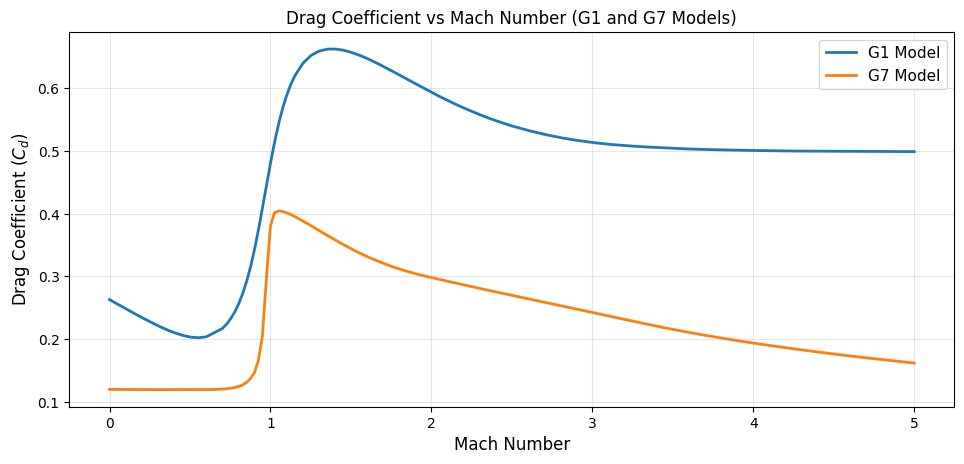

In [41]:
# In-class - create a ballistics model that stores and retrieves the data in the above arrays in such a way as to 
# allow the plots below to be constructed.

class Ballistics():
    #class level model
    _models = {}
    
    @classmethod
    #Receives class, not itself (cls vs self)
    #class based instance of interpolation function saves memory. Basically when the first ballistics
    #object looks for a particular model it will read the csv and add that to models. Subsequent calls
    #to _get_model will use this
    def _get_model(cls, reference_model):
        if reference_model not in cls._models:
            if reference_model == "G1":
                data = pd.read_csv('G1.csv').values
            elif reference_model == "G7":
                data = pd.read_csv('G7.csv').values
                
            cls._models[reference_model] = interp1d(data[:, 0], data[:, 1])
            
        return cls._models[reference_model]
    
    def __init__(self, g=9.8, p=1.225, B_c=1, cartridge=None, bullet=None, reference_model="G1",
                 mach_numbers=None, bc_values=None):
        #gravity
        self.g = g
        #air density in kg/m^3
        self.p = p
        #Cartdige name
        self.cartridge = cartridge
        self.bullet = bullet
        
        # Get shared reference model from class cache (no redundant file reads)
        self.model = Ballistics._get_model(reference_model)
        self.reference_model = reference_model
        
        # If mach_numbers and bc_values are provided, create an interpolated B_c function
        # Otherwise, use the scalar B_c value (converted from lb/in^2 to kg/m^2)
        if mach_numbers is not None and bc_values is not None:
            bc_metric = np.array(bc_values) * 703
            self.B_c = interp1d(mach_numbers, bc_metric, fill_value="extrapolate")
        else:
            self.B_c = B_c * 703
        
    def B_C(self, mach_number):
        #If we have a bc interpolation function, return that value else our singular ballistic coefficient.
        if callable(self.B_c):
            return self.B_c(mach_number)
        else:
            return self.B_c
        
    def Kd_to_Cd(self, Kd):
        #Correct data to coefficient of drag
        return (np.pi/4)*Kd
    
    def Cd(self, mach_number):
        #Get interpolated coefficient of drag from reference model
        return self.Kd_to_Cd(self.model(mach_number))
        
    def mach_number(self, velocity):
        #Assuming velocity is meters/second
        return (velocity/343)

    def velocity(self, mach_number):
        #Assuming velocity is meters/second
        return (mach_number*343)
    
    def get_drag(self,v):
        # Computes the drag resistance
        # this is unsigned and should be
        # working against the direction of motion
        # This also is computed with 1/m already accounted for
        # so it is acceleration, not force.,
        
        v_mag = abs(v)
        #print(f"Calculating drag: v_mag: {v_mag}")
        
        mach = self.mach_number(v_mag)
        
        # Computes the drag acceleration magnitude (unsigned)
        # Use B_C() so it works for both scalar and interpolated B_c
        toReturn = 0.5 * (1/self.B_C(mach)) * self.p
        toReturn *= self.Cd(mach)
        toReturn *= v_mag**2
        return toReturn


ballistics_G1 = Ballistics()
ballistics_G7 = Ballistics(reference_model="G7")

G1_Cd = []
G7_Cd = []
machs = []

mach_step = .001
mach_range = [0,5]

numsteps = int((mach_range[1]-mach_range[0])/mach_step)

for i in range(numsteps):
    mach_no = (i*mach_step)+mach_range[0]
    
    machs.append(mach_no)
    G1_Cd.append(ballistics_G1.model(mach_no))
    G7_Cd.append(ballistics_G7.model(mach_no))

plt.figure(figsize=(10, 5))
plt.plot(machs, G1_Cd, linewidth=2, label='G1 Model')
plt.plot(machs, G7_Cd, linewidth=2, label='G7 Model')
plt.xlabel('Mach Number', fontsize=12)
plt.ylabel('Drag Coefficient ($C_d$)', fontsize=12)
plt.title('Drag Coefficient vs Mach Number (G1 and G7 Models)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout(pad=2.0)
plt.show()



### Assignment
* Develop a class to encapsulate the data for the G1 and G7 models. These data are expressed in the tables that appear below. The class should also have a function to return the drag at any Mach number. To do this you will have to interpolate between measured values. I suggest `scipy.interpolate.interp1d`.
* Select three rifle cartridges trajectory data and ballistic coefficients from this table at [Hornady](https://static.hornady.media/presscenter/docs/1410998059-2022-Metric-Ballistics-Chart.pdf). Note that I've converted this PDF table to CSV format for you and placed it on the course Canvas. Let your interest guide you, but you might consider one larger, one medium, and one smaller in terms of the mass of the bullet.
* You will need to devise a method for making certain that the projectile is zeroed at the appropriate point on the trajectory. To do this, the projectile must be fired at an angle with respect to horizontal making initial velocities $v^0_x = v_m cos\theta$ and $v^0_y = v_m sin\theta$, where $v_m$ is the muzzle velocity of the cartridge you select. The data provided are all sited in at 100 m. Hence you will have to adjust the initial angle, until the bullet is right at 0 at 100 m. This is an optimization problem. Come up with a means of doing this, either on your own, or by learning to use something like `scipy.optimize.fmin`.
* Take into account the scope is above the barrel. As such, the initial position in -5 cm below the zero. This is seen in the Hornady tables, provided above.
* Compare the trajectory of the cartridges you select to the trajectory recorded in the tables. Do so with both elevation and velocity.
* Develop a quantitative metric for assessing the ''goodness of fit'' of the model to the data, for example, sum square error (SSE). Use this to make comparisons between the rounds tested. For which round does the G1 model perform best?
* Now, find rounds that have G7 ballistic coefficient reported, as well as tragectory data. Here is a summary: [Hornady bullet G7 BCs](https://www.hornady.com/bc) Do the same analysis as in the previous part, but now compare G1 and G7 ballistic models. According to your metric, which does better? For which rounds? *Note that this portion is not a prescriptive as the others, there are many ways to incorporate Hornady's G7 data...*
* And, for bragging rights -- some students like this assignment a lot. If you're one of those, see if you can do a better job of answering the following question *Based on model results, which cartridge goes the greatest distance never deviating more than 5 cm above or below the line of site of the shooter?* This is inspired by the GEE data in the table, so you might begin by reading how that is done.


In [42]:
#Read CSV, double header so accessing will require both header infos
hornady_df = pd.read_csv('hornady_ballistics.csv', header=[0, 1])

#Get names for velocity columns at range intervals
ranges = [0, 50, 100, 150, 200, 250, 300]
velocity_cols = [('Velocity (m/sec)', str(r)+'m') for r in ranges]
energies_cols = [('Energy (joules)', str(r)+'m') for r in ranges]
trajectory_cols = [('Trajectory Tables (cm)', str(r)+'m') for r in ranges]
gee_cols = [('GEE Trajectory', str(r)+'m') for r in ranges]

#load all bullets from csv
all_velocity_data = []
all_drop_data = []
all_ballistics_G1 = []
all_ballistics_G7 = []

for index in range(len(hornady_df)):
    row = hornady_df.iloc[index]
    
    #perhaps redundant to store ranges for each velocity and drop but this keeps it generalizable if we get data that
    #has different ranges
    velocity = np.array([[r, row[col]] for r, col in zip(ranges, velocity_cols) 
                          if not pd.isna(row[col])], dtype=float)
    all_velocity_data.append(velocity)
    
    drop = np.array([[r, row[col]] for r, col in zip(ranges, trajectory_cols) 
                          if not pd.isna(row[col])], dtype=float)
    
    #convert cm to meters on data intake to simplify things
    if len(drop) > 0:
        drop[:, 1] = drop[:, 1] / 100
    all_drop_data.append(drop)
    
    #Get other data for bullet
    B_c = row[('B.C.', 'B.C.')]
    cartridge = row[('CARTRIDGE','CARTRIDGE')]
    bullet = row[('BULLET','BULLET')]
    
    all_ballistics_G1.append(Ballistics(B_c=B_c,cartridge=cartridge,bullet=bullet,reference_model="G1"))
    all_ballistics_G7.append(Ballistics(B_c=B_c,cartridge=cartridge,bullet=bullet,reference_model="G7"))

print(f"Loaded {len(all_ballistics_G1)} bullets from Master CSV.")

#selected bullet indices
bullet_indices = [7,8,9,13,18,50,84,100,150,257,259]

def printCartridges(indices=None):
    """Print cartridge info. Defaults to bullet_indices if no indices given."""
    if indices is None:
        indices = bullet_indices
    for i in indices:
        bal = all_ballistics_G1[i]
        print(f"{i}: Cartridge: {bal.cartridge}. Bullet: {bal.bullet}. Ballistic Coefficient: {bal.B_c/703}")
        
printCartridges()

# Single header CSV for Mach-dependent BC values
expanded_df = pd.read_csv('hornady_bc_values.csv')

Loaded 260 bullets from Master CSV.
7: Cartridge: 204 Ruger. Bullet: 24 gr. NTX (26" Bbl). Ballistic Coefficient: 0.17
8: Cartridge: 204 Ruger. Bullet: 32 gr. V-MAX (26" Bbl). Ballistic Coefficient: 0.21
9: Cartridge: 204 Ruger. Bullet: 40 gr. V-MAX (26" Bbl). Ballistic Coefficient: 0.275
13: Cartridge: 22 LR. Bullet: 40 gr. HP Copper Plated. Ballistic Coefficient: 0.12
18: Cartridge: 222 Rem. Bullet: 50 gr. V-MAX. Ballistic Coefficient: 0.24200000000000002
50: Cartridge: 243 Win. Bullet: 87 gr. SST. Ballistic Coefficient: 0.39999999999999997
84: Cartridge: 6.5 Creedmoor. Bullet: 140 gr. BTHP. Ballistic Coefficient: 0.58
100: Cartridge: 270 WSM. Bullet: 130 gr. CX. Ballistic Coefficient: 0.403
150: Cartridge: 308 Win. Bullet: 178 gr. BTHP. Ballistic Coefficient: 0.53
257: Cartridge: 500 Nitro Express 3". Bullet: 570 gr. DGX Bonded. Ballistic Coefficient: 0.295
259: Cartridge: 50 BMG. Bullet: 750 gr. A-MAX (36" Bbl). Ballistic Coefficient: 1.05


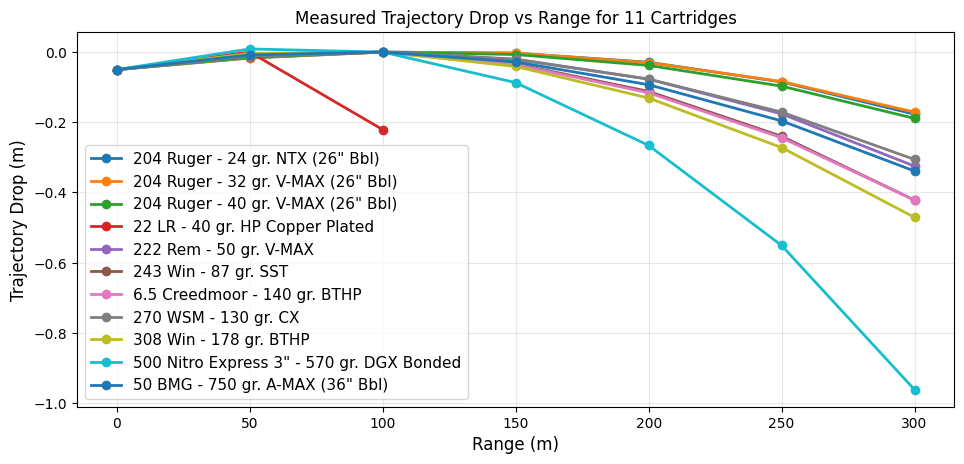

In [43]:
#Simulate Trajectories

plt.figure(figsize=(10, 5))
for i in bullet_indices:
    bal = all_ballistics_G1[i]
    plt.plot(all_drop_data[i][:, 0], all_drop_data[i][:, 1], linewidth=2, marker='o', label=f"{bal.cartridge} - {bal.bullet}")
plt.xlabel('Range (m)', fontsize=12)
plt.ylabel('Trajectory Drop (m)', fontsize=12)
plt.title(f'Measured Trajectory Drop vs Range for {len(bullet_indices)} Cartridges', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout(pad=2.0)
plt.show()

trajectory = []

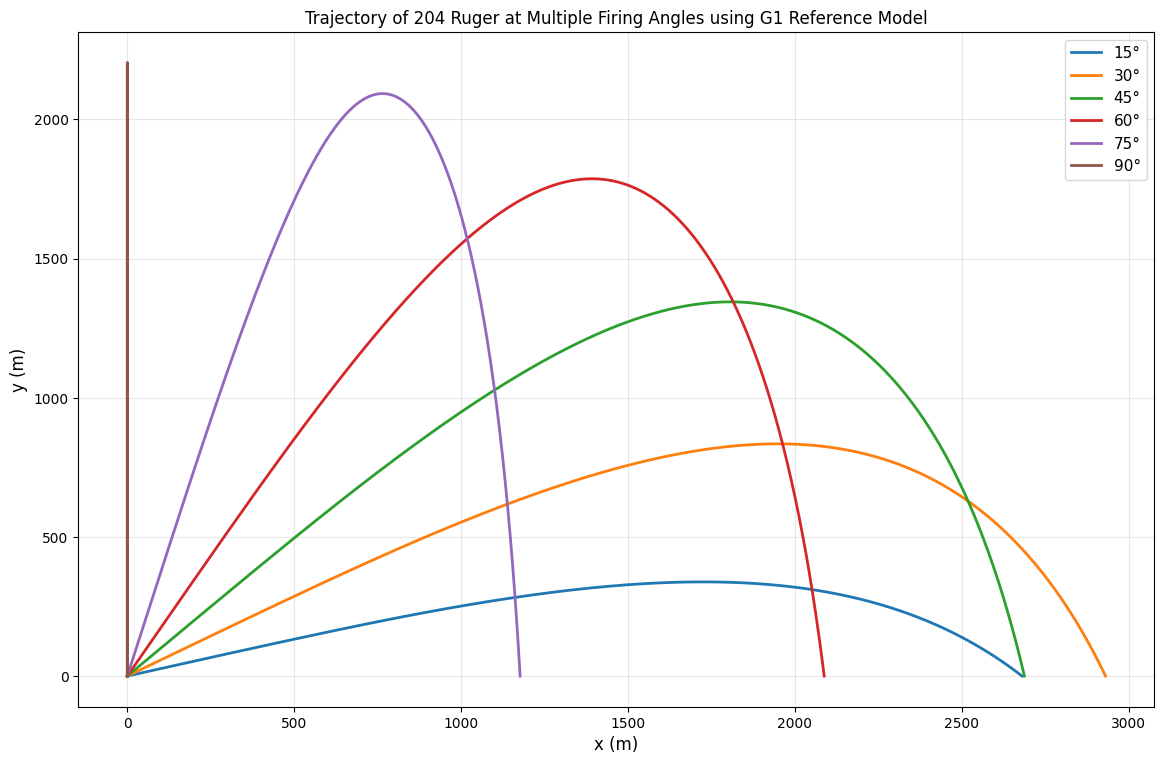

In [44]:
firing_angles = [15, 30, 45, 60, 75, 90]
test_idx = bullet_indices[1]
timespan = [0,50]
vel_test = all_velocity_data[test_idx][:,1][0]

plt.figure(figsize=(12, 8))

for firing_angle in firing_angles:
    firing_angle_rad = np.deg2rad(firing_angle)
    vx_0 = vel_test * np.cos(firing_angle_rad)
    vy_0 = vel_test * np.sin(firing_angle_rad)
    
    y0 = np.array([0, -0.05, vx_0, vy_0])
    
    y, t = funcs.solve_ode(projectile, timespan, y0, funcs.EulerRichardson, all_ballistics_G1[test_idx], first_step=0.0005,y_ground=-.05)
    plt.plot(y[:, 0], y[:, 1], linewidth=2, label=f'{firing_angle}°')

plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.title(f'Trajectory of {all_ballistics_G1[test_idx].cartridge} at Multiple Firing Angles using G1 Reference Model')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout(pad=2.0)
plt.show()

In [45]:
# Zeroing rifle
from scipy.optimize import fmin

def zero_cartridge(csv_idx, model="G1", scope_offset=-0.05, y_target=0, zero_range=None, tspan=[0,5], dt=0.002, ballistic_object = None):
    if ballistic_object is None:
        if model == "G1":
            ballistic_object = all_ballistics_G1[csv_idx]
        else:
            ballistic_object = all_ballistics_G7[csv_idx]
    #Get initial velocity
    v0 = all_velocity_data[csv_idx][:,1][0]
    
    optimal_angle = fmin(zero_cost, .1, args=(ballistic_object, v0, tspan, dt, scope_offset, y_target, zero_range), disp=False)
    return optimal_angle[0]
     
#Function to find how far a given trial is from being zerod at zero range. Uses squared error
def zero_cost(angle_deg, bal, v0, tspan, dt, scope_offset, y_target, zero_range):
    #Convert angle to radians
    angle_rad = np.deg2rad(angle_deg[0])  
    vx_0 = v0 * np.cos(angle_rad)
    vy_0 = v0 * np.sin(angle_rad)
    
    y0 = np.array([0, scope_offset, vx_0, vy_0])
    
    y, t = funcs.solve_ode(projectile, tspan, y0, funcs.EulerRichardson, bal, first_step=dt)
    
    x_data = y[:, 0]
    y_data = y[:, 1]
    
    #High cost if bullet didn't reach zero range
    if x_data[-1] < zero_range:
        return 1000
    
    #Interpolate ode data to get ODE simulated y value at zero range
    y_at_x = interp1d(x_data, y_data)
    y_at_zero_range = y_at_x(zero_range)
    
    #Return difference squared
    return (y_target - y_at_zero_range)**2

7: Cartridge: 204 Ruger. Bullet: 24 gr. NTX (26" Bbl). Ballistic Coefficient: 0.17
8: Cartridge: 204 Ruger. Bullet: 32 gr. V-MAX (26" Bbl). Ballistic Coefficient: 0.21
9: Cartridge: 204 Ruger. Bullet: 40 gr. V-MAX (26" Bbl). Ballistic Coefficient: 0.275
13: Cartridge: 22 LR. Bullet: 40 gr. HP Copper Plated. Ballistic Coefficient: 0.12
18: Cartridge: 222 Rem. Bullet: 50 gr. V-MAX. Ballistic Coefficient: 0.24200000000000002
50: Cartridge: 243 Win. Bullet: 87 gr. SST. Ballistic Coefficient: 0.39999999999999997
84: Cartridge: 6.5 Creedmoor. Bullet: 140 gr. BTHP. Ballistic Coefficient: 0.58
100: Cartridge: 270 WSM. Bullet: 130 gr. CX. Ballistic Coefficient: 0.403
150: Cartridge: 308 Win. Bullet: 178 gr. BTHP. Ballistic Coefficient: 0.53
257: Cartridge: 500 Nitro Express 3". Bullet: 570 gr. DGX Bonded. Ballistic Coefficient: 0.295
259: Cartridge: 50 BMG. Bullet: 750 gr. A-MAX (36" Bbl). Ballistic Coefficient: 1.05


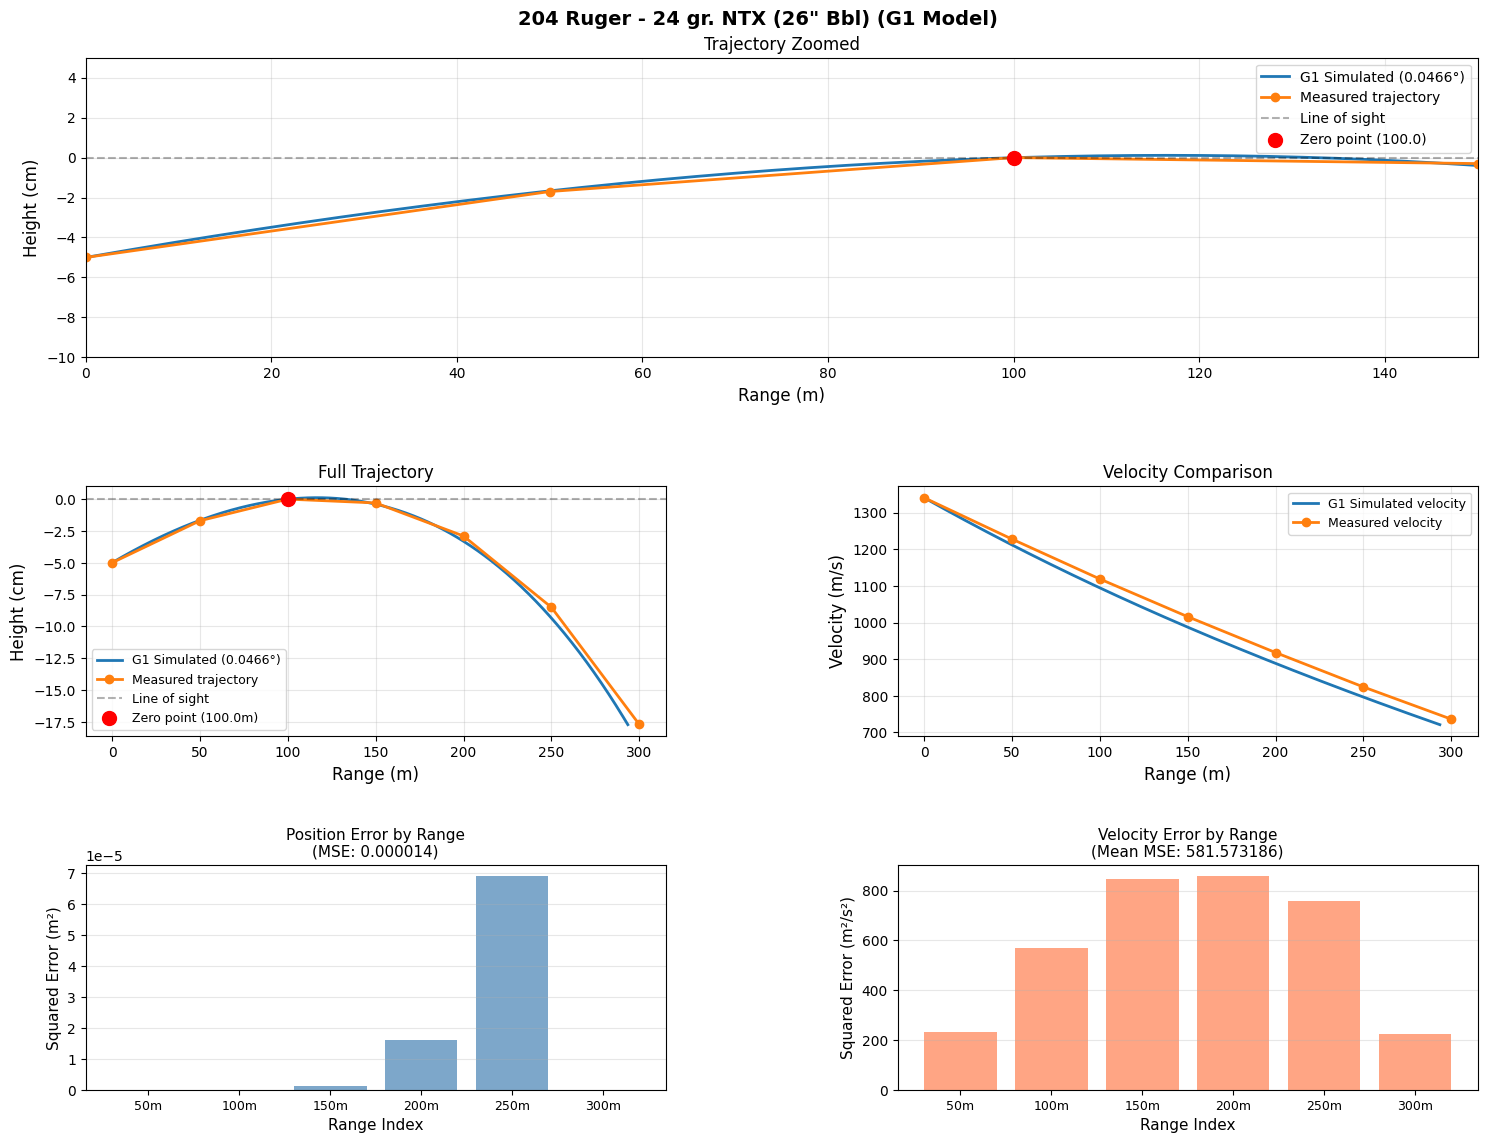

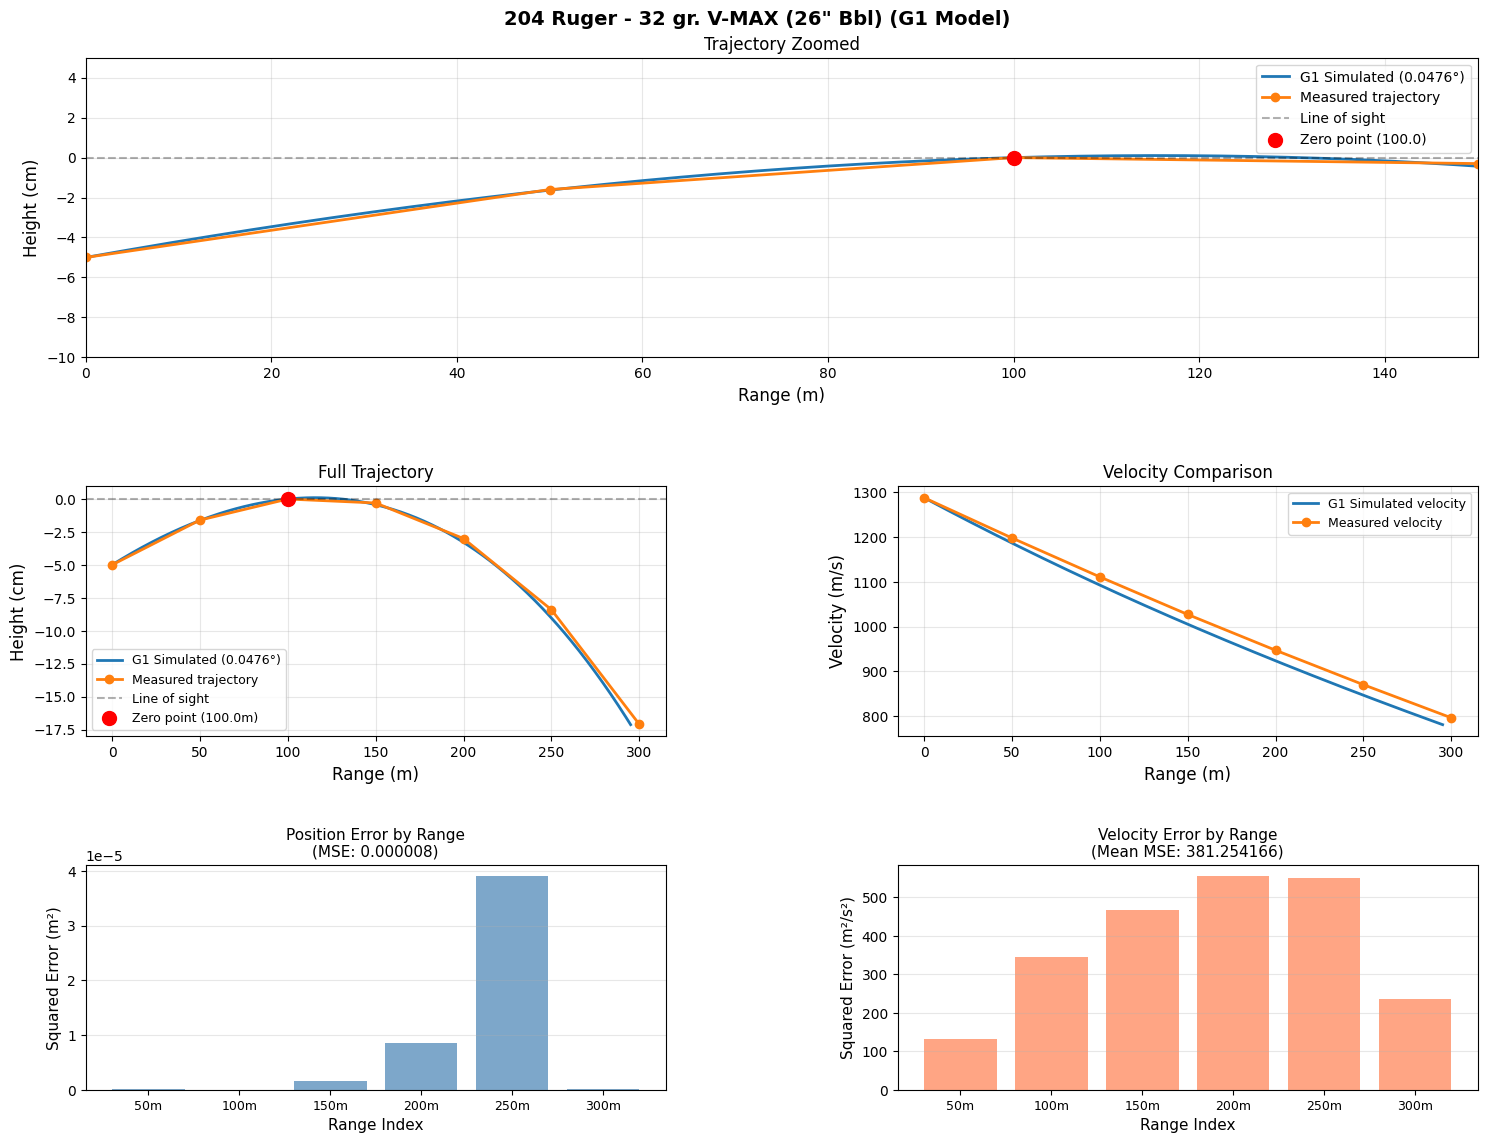

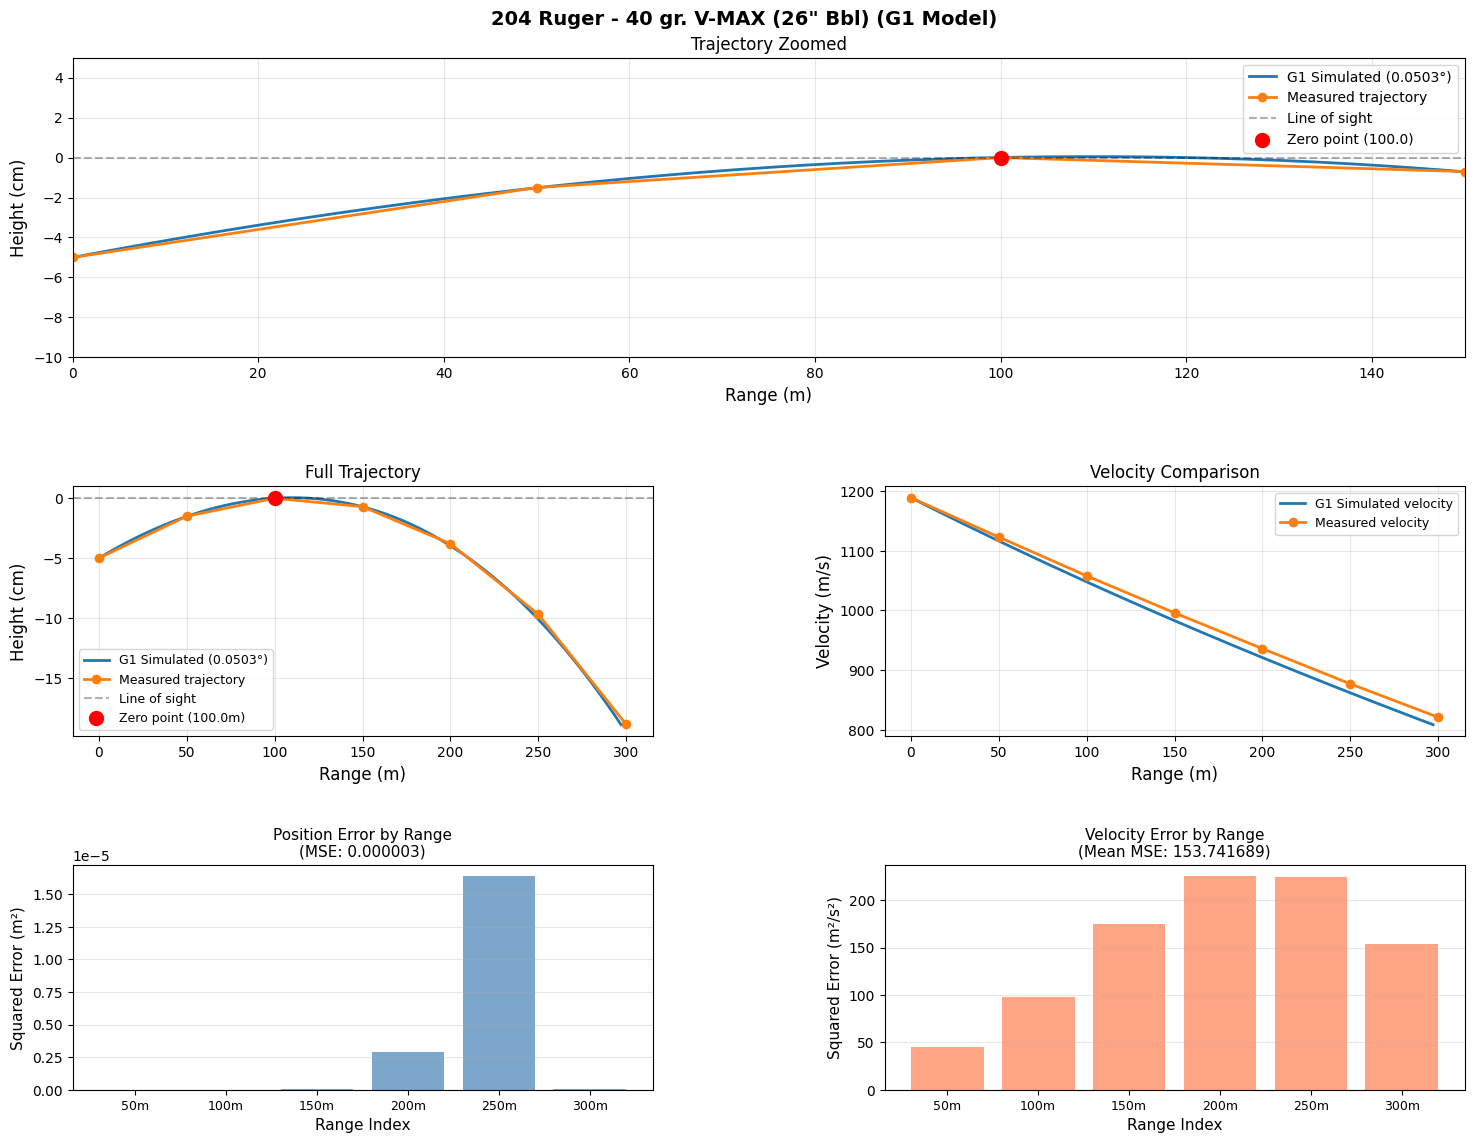

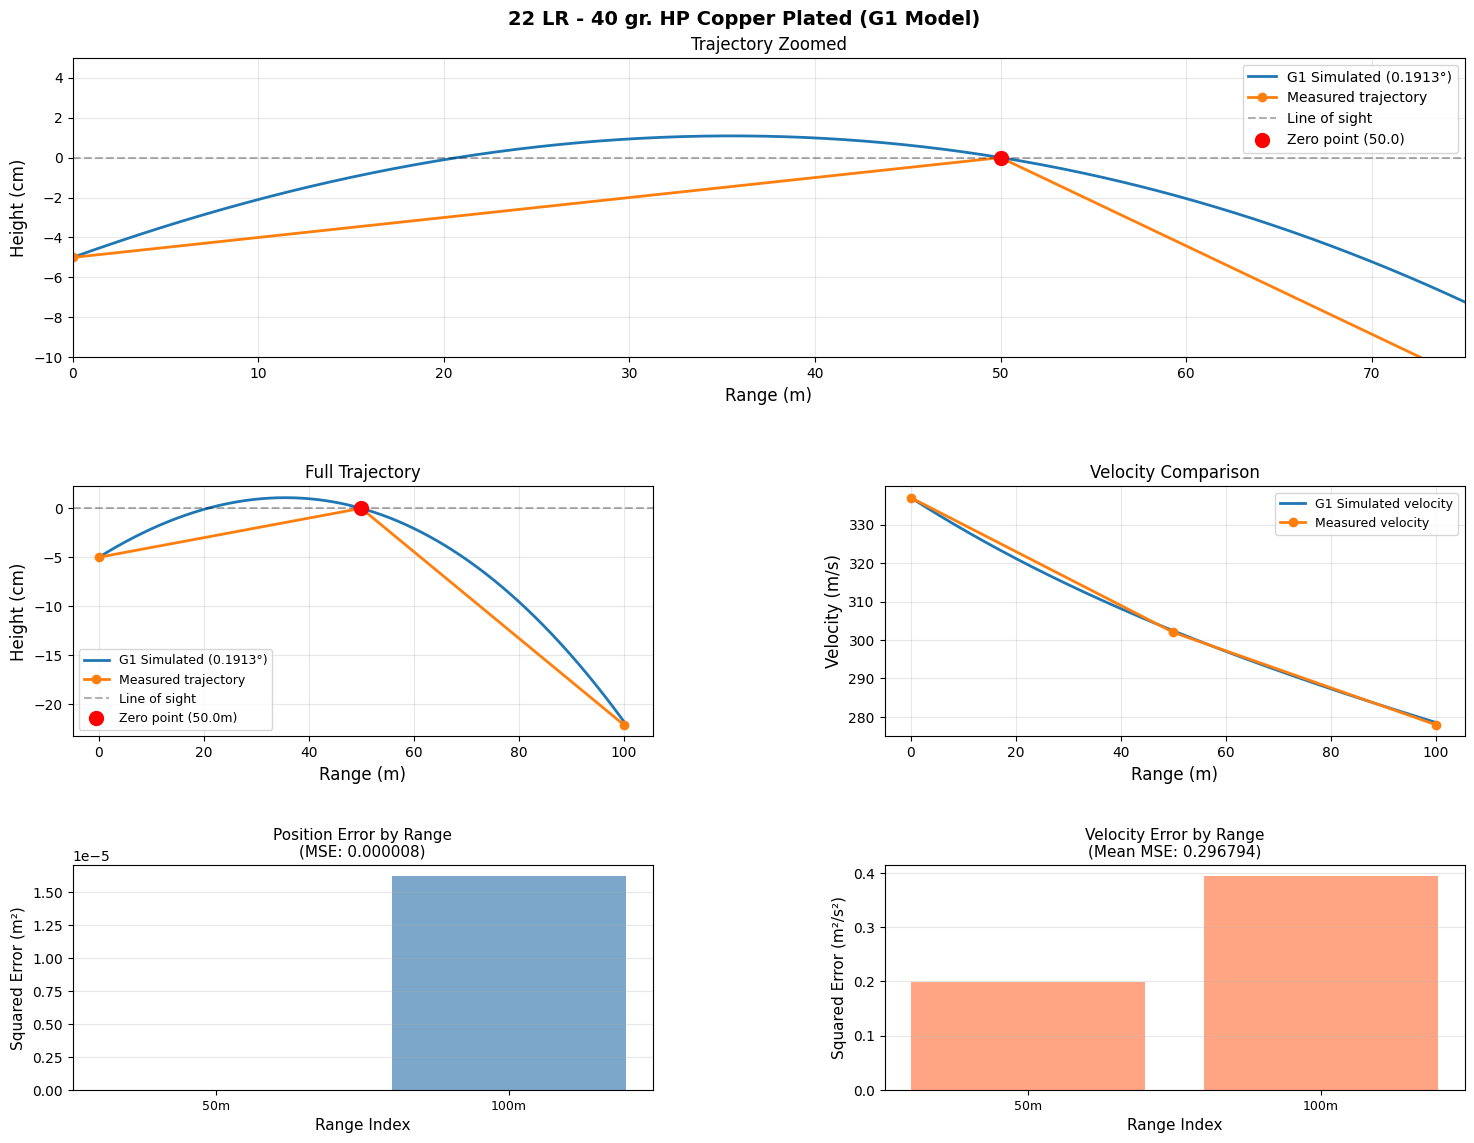

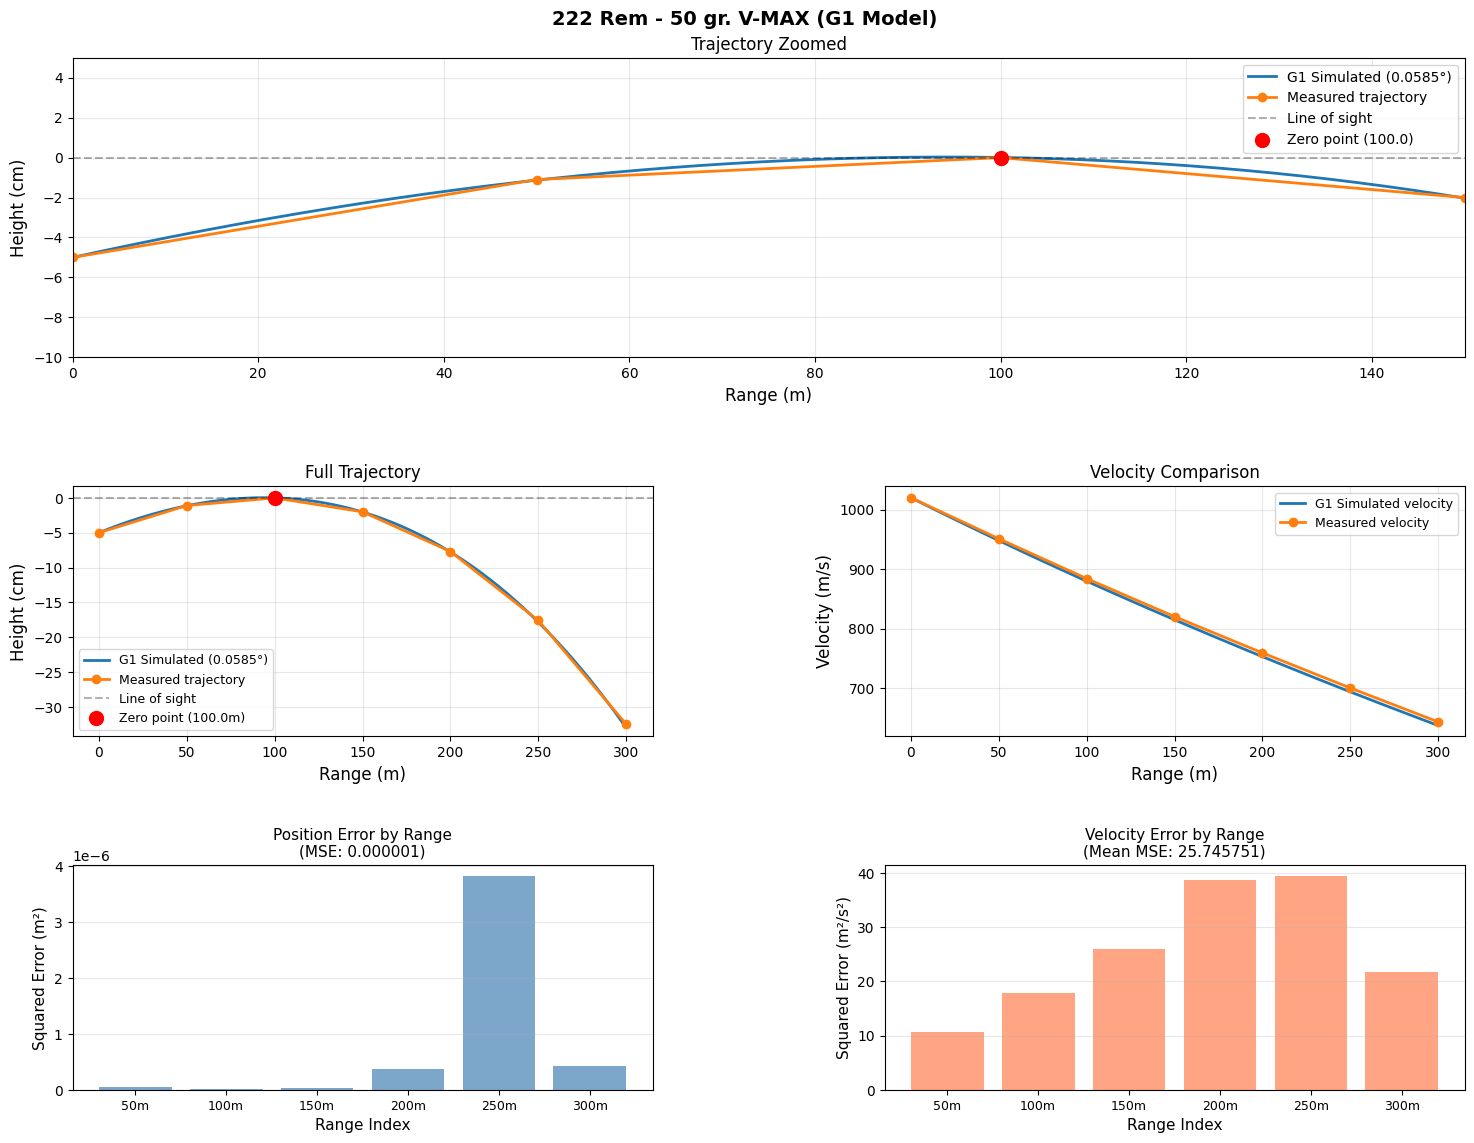

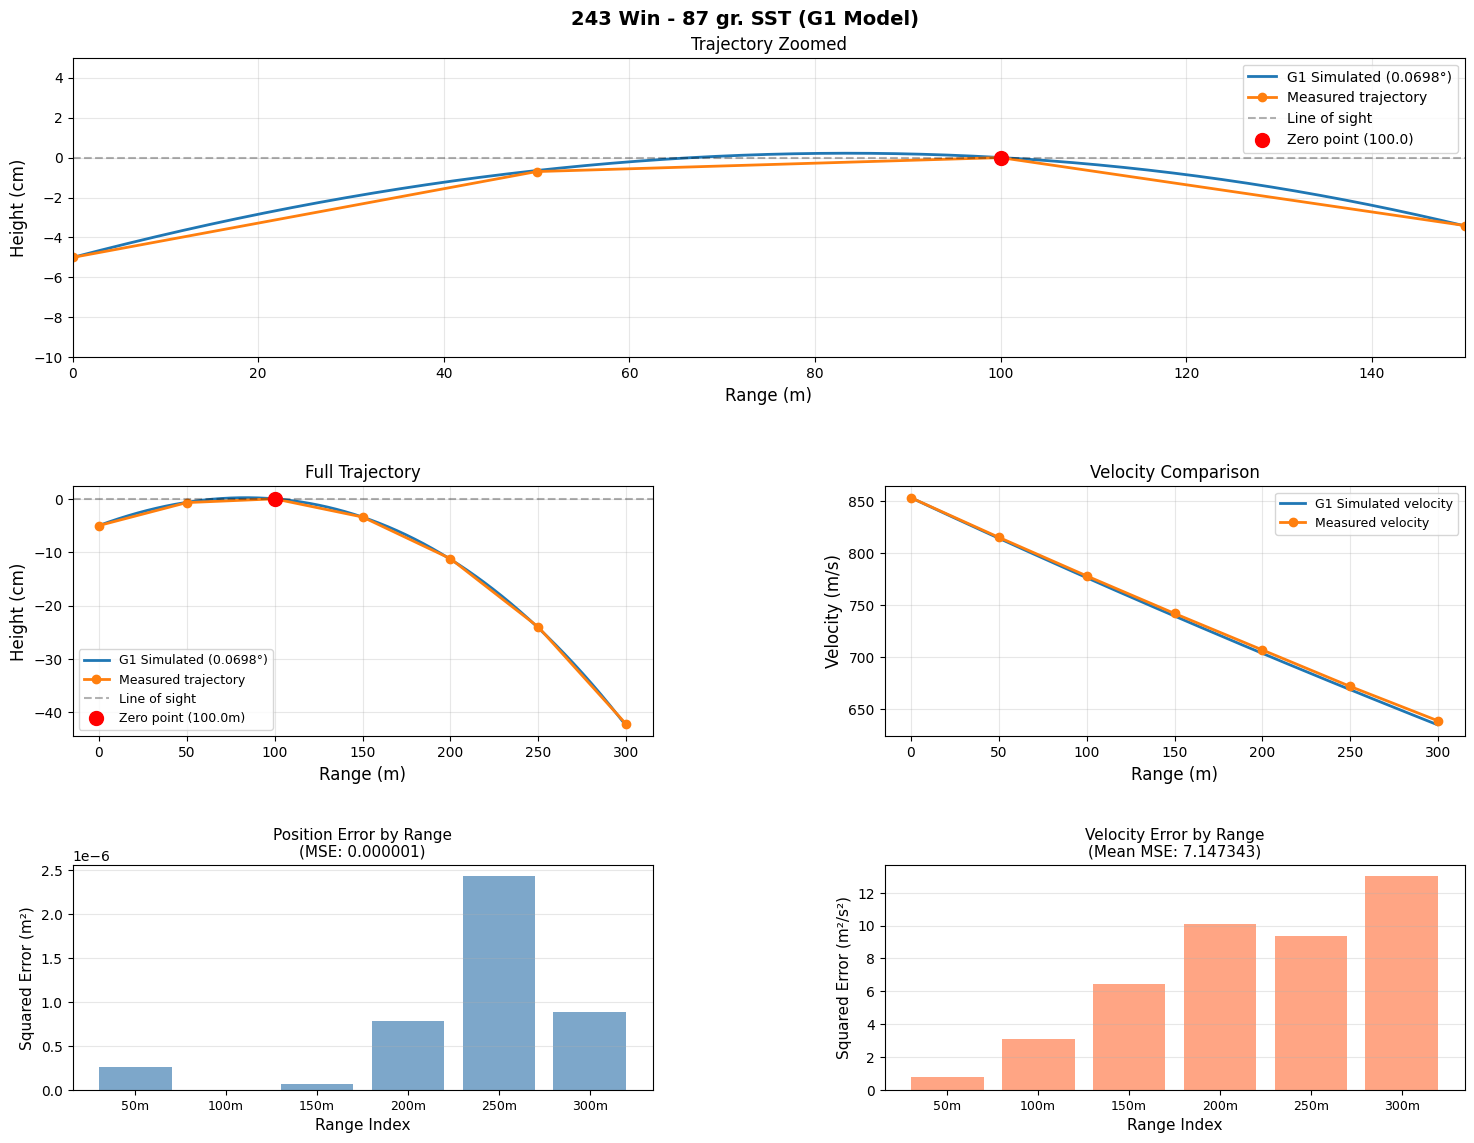

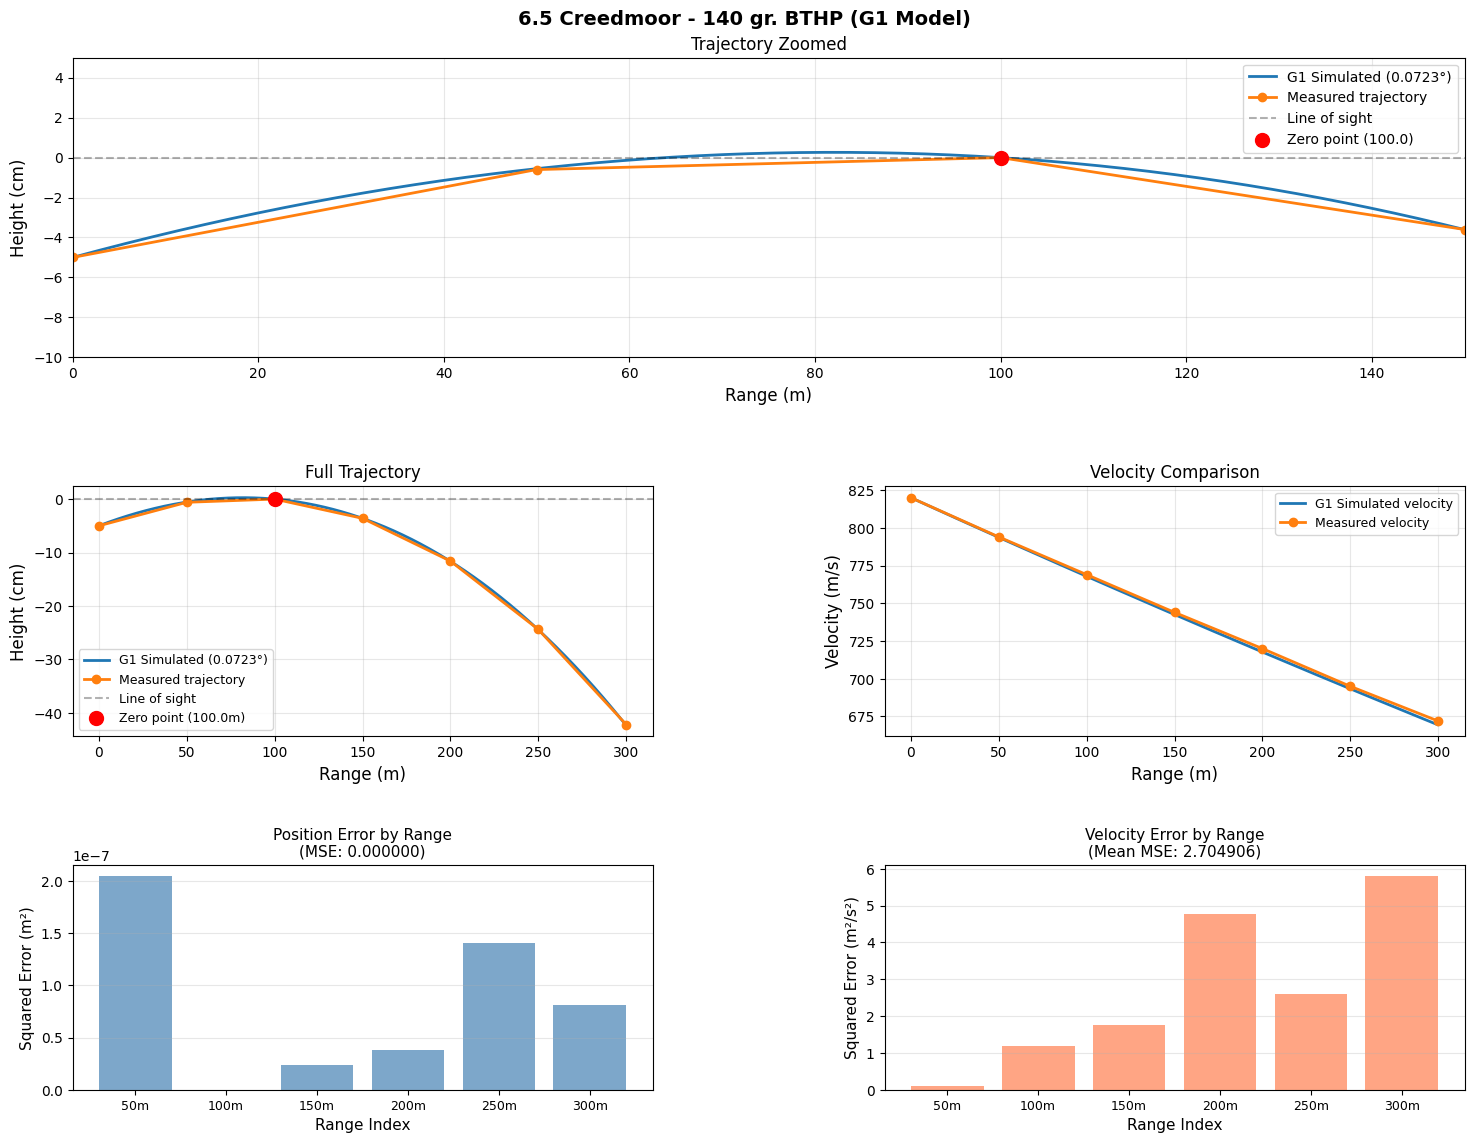

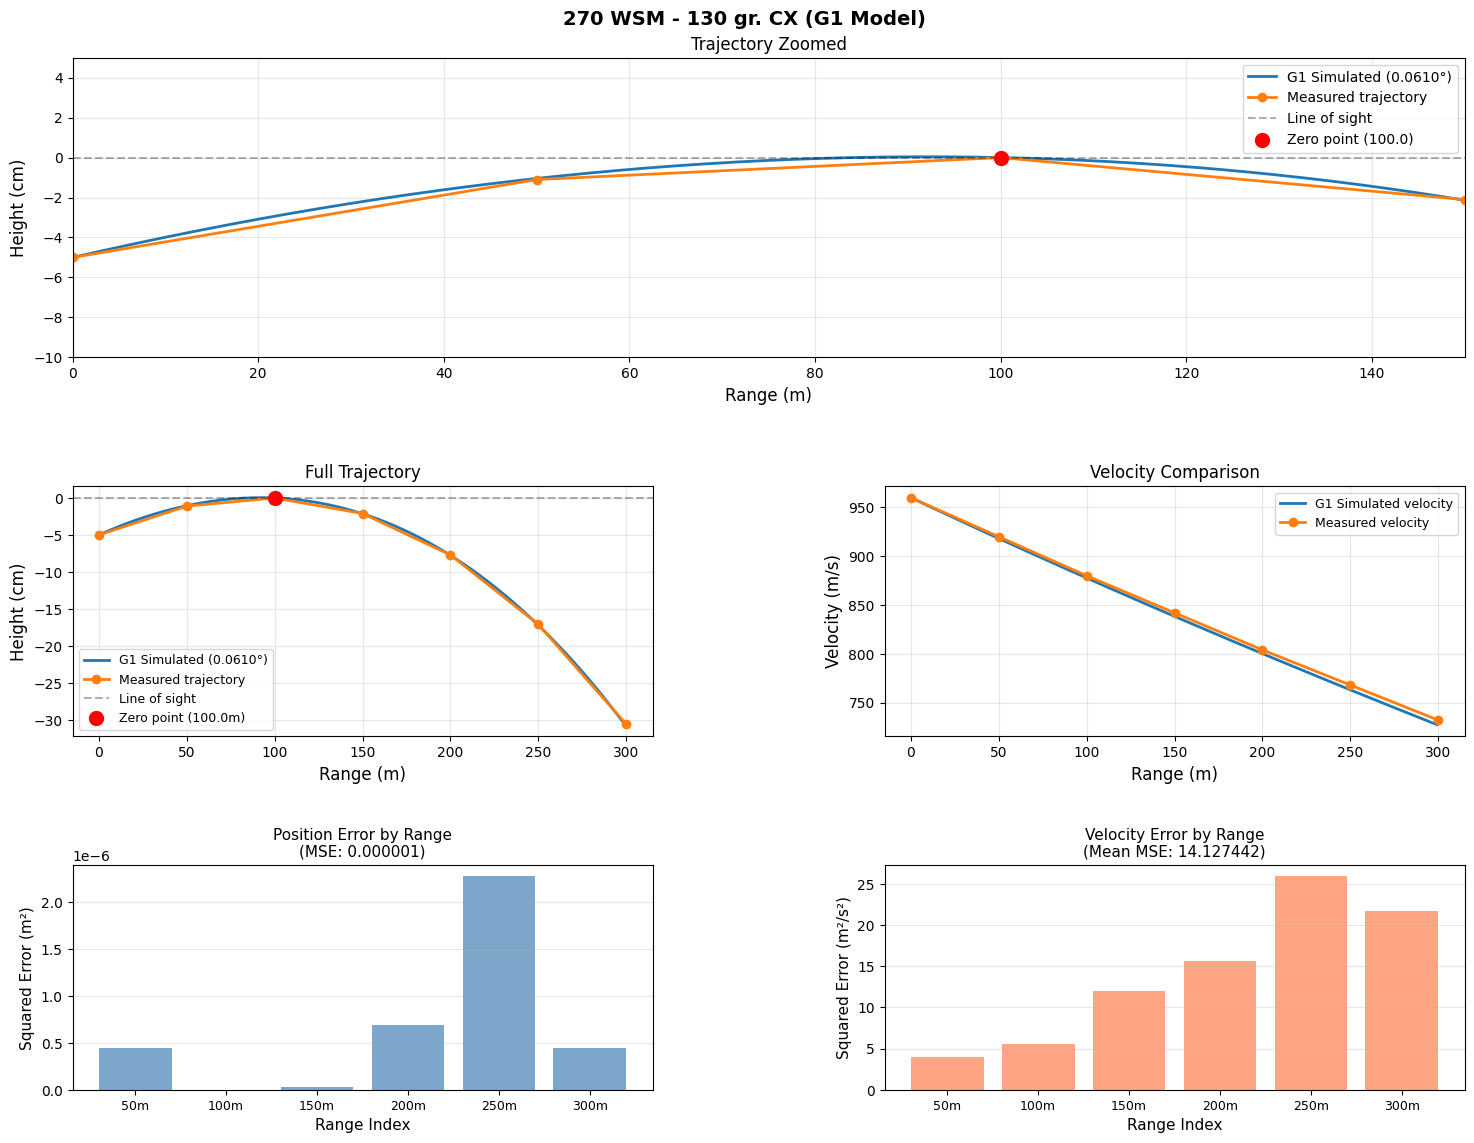

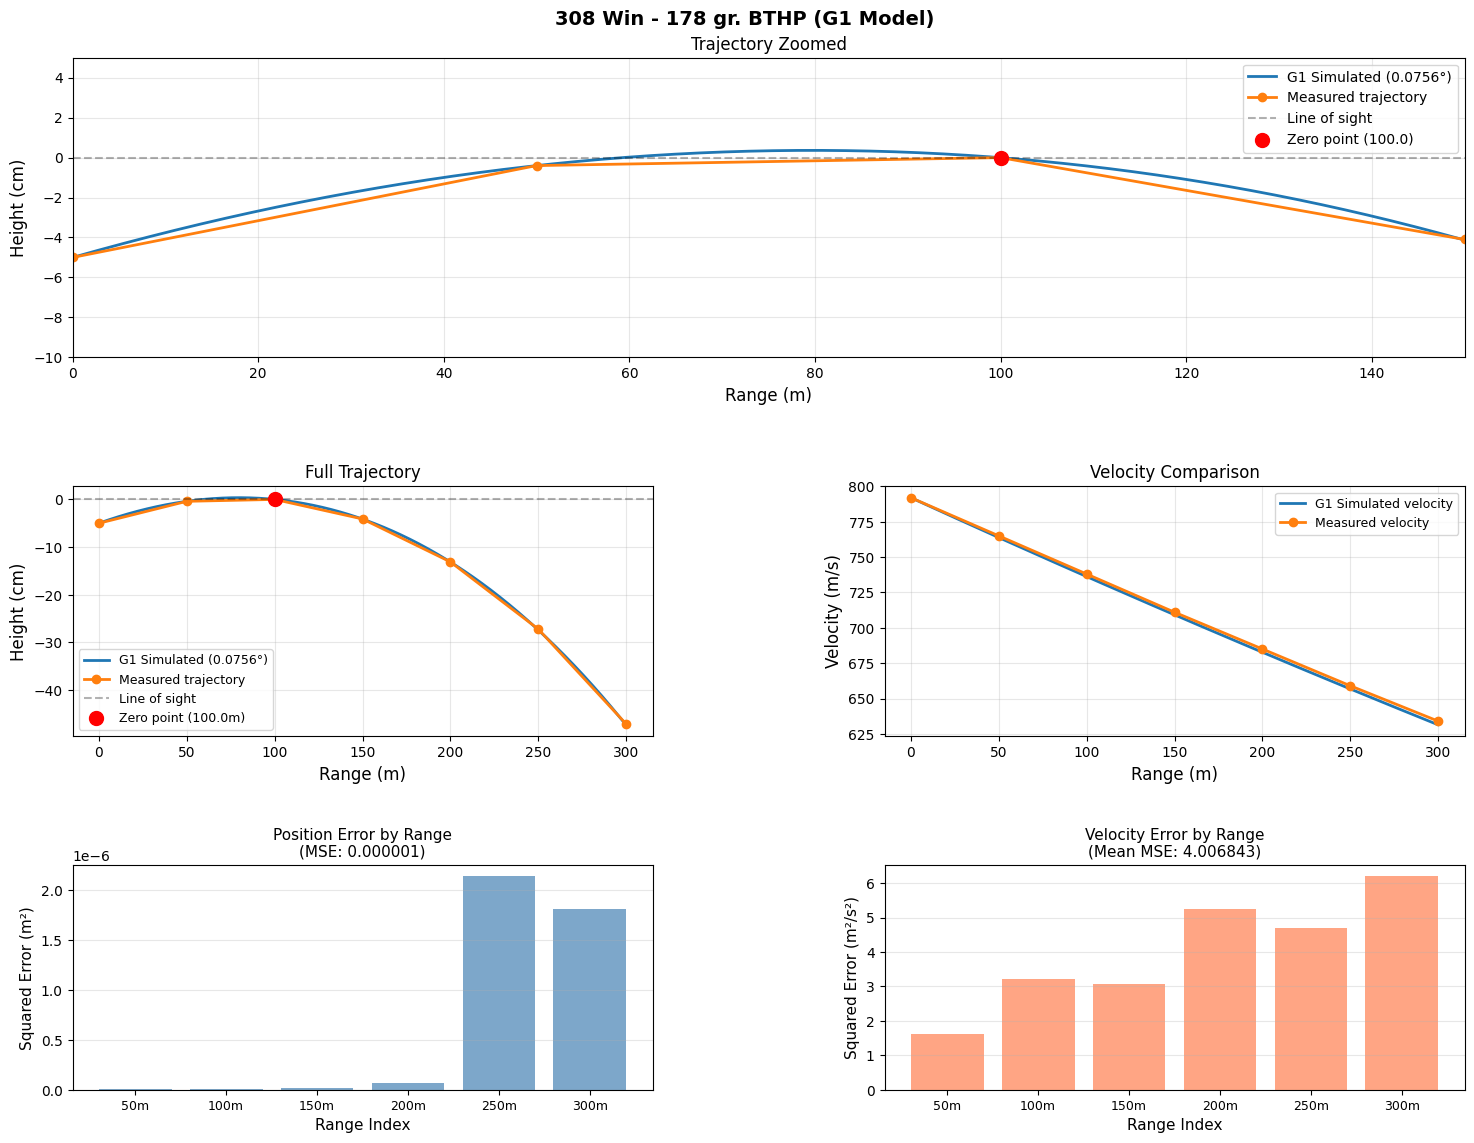

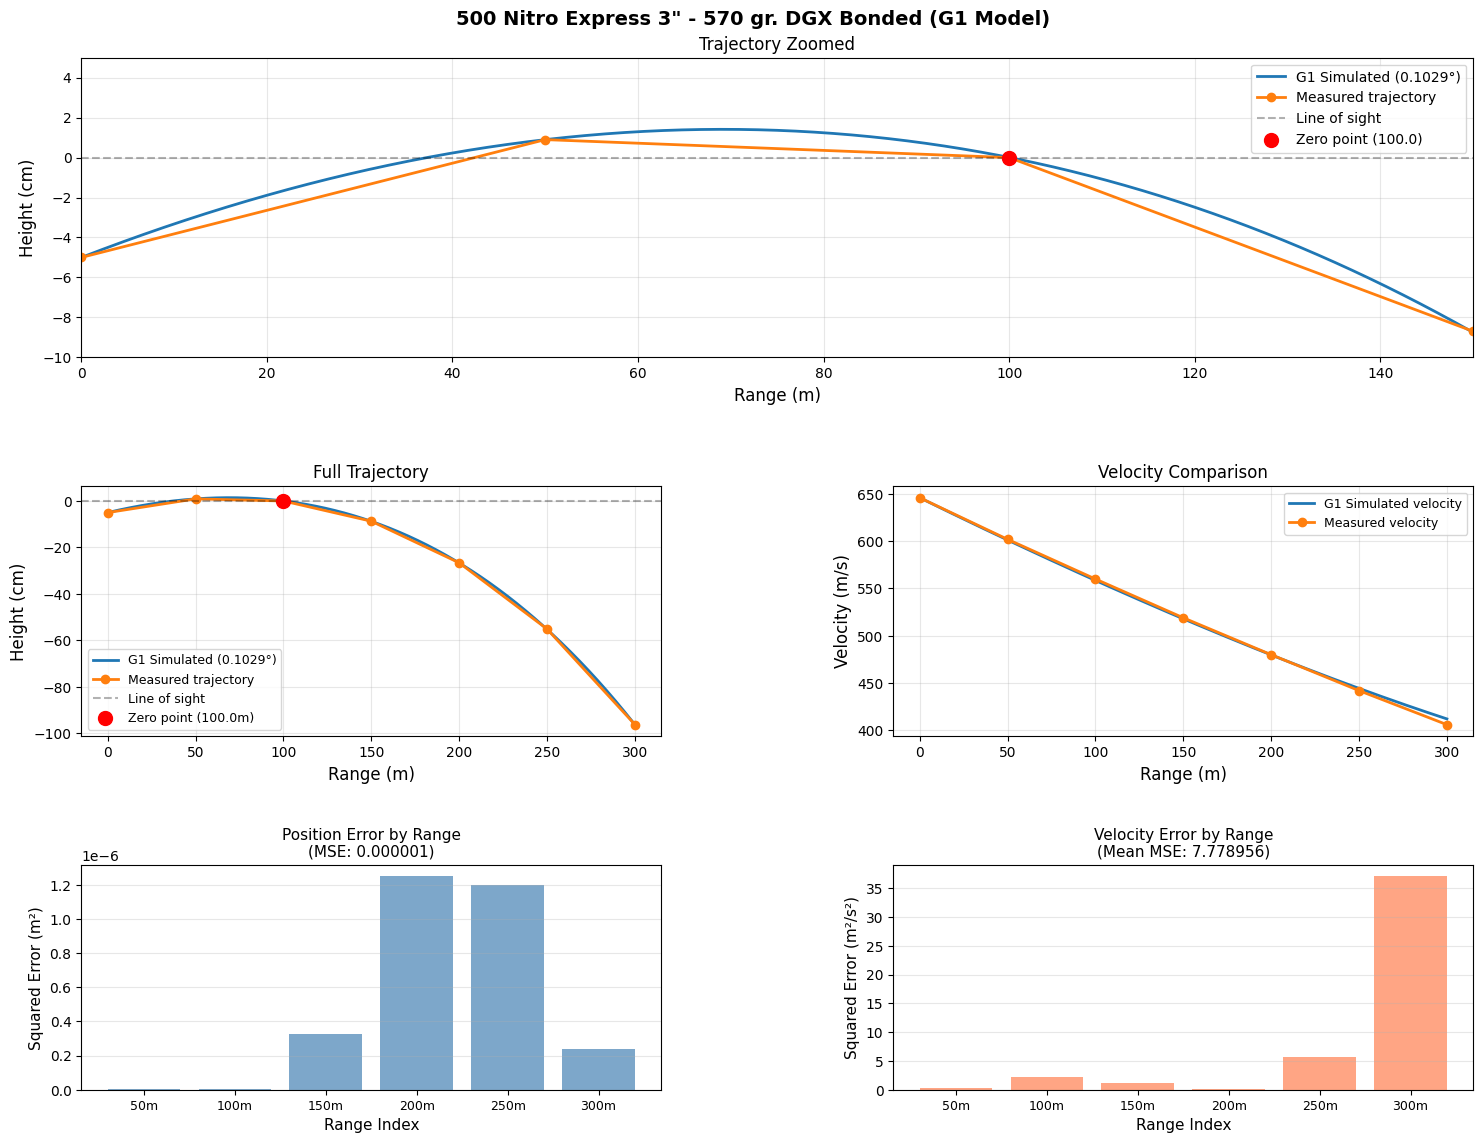

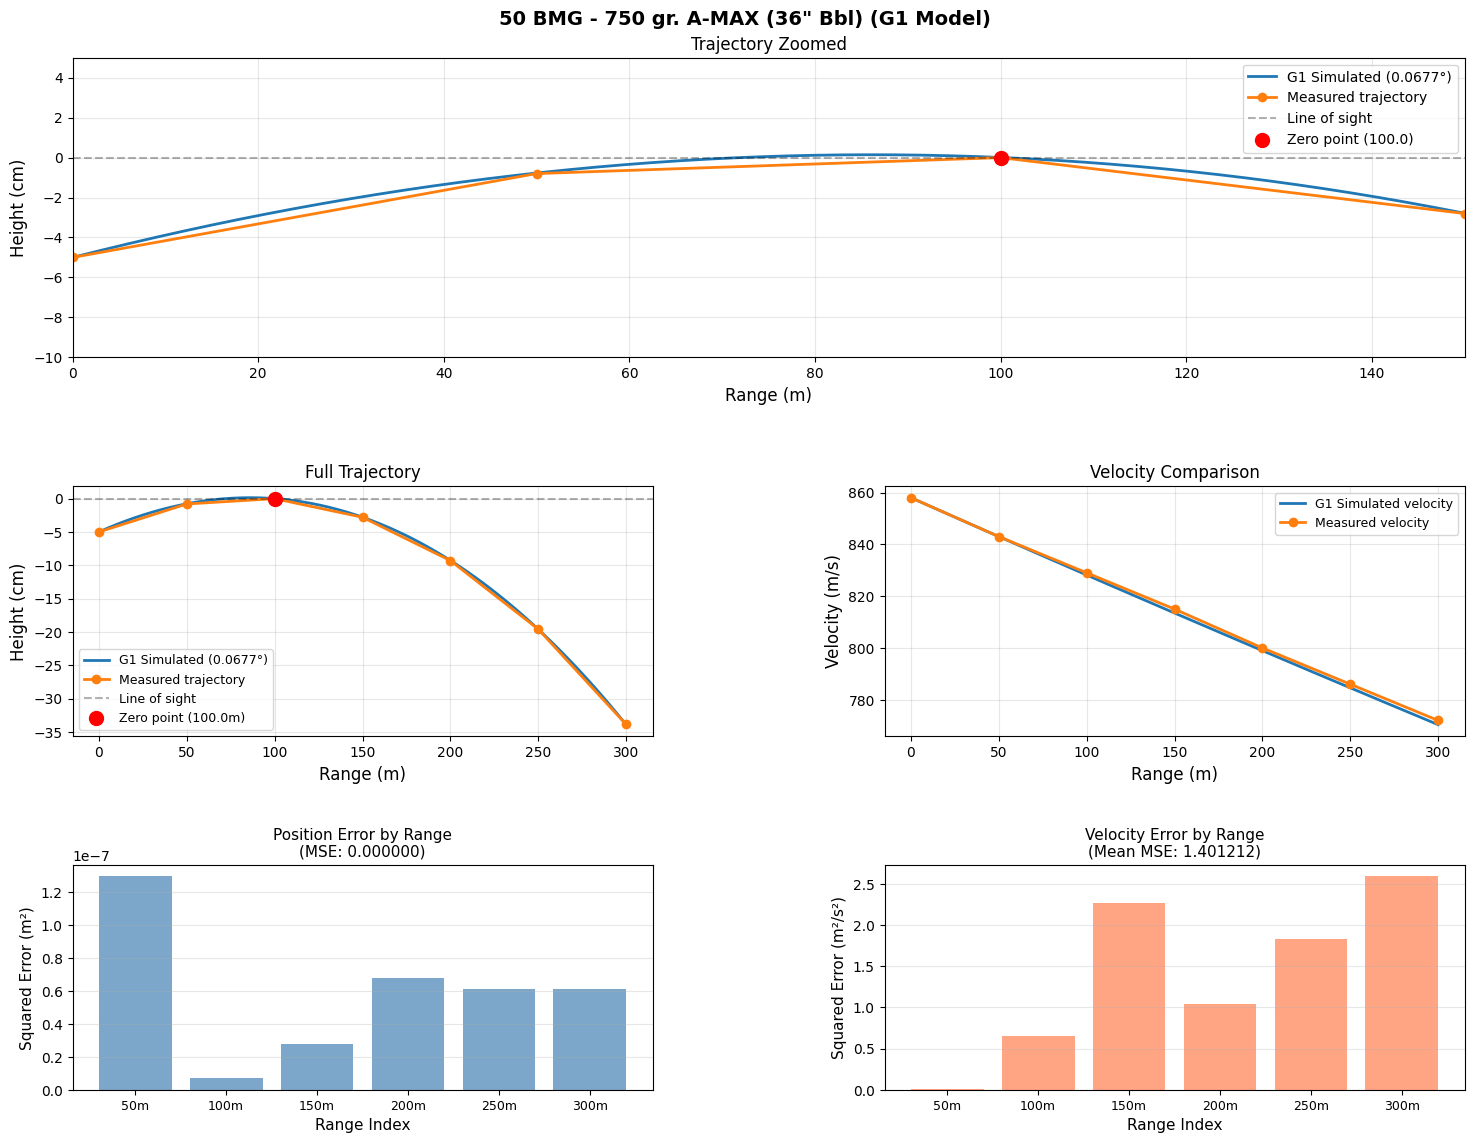

In [46]:
from matplotlib.gridspec import GridSpec

def analyze_cartridge(csv_idx, plot=True,model="G1", printt=False):
    #get ballistic object and zero the cartridge
    if model == "G1":
        ballistic = all_ballistics_G1[csv_idx]
    else: 
        ballistic = all_ballistics_G7[csv_idx]
        
    #Find index in drop data where the bullet hits 0
    zero_index = np.argmin(np.abs(all_drop_data[csv_idx][:,1]))
    #Use that index to get the range at which it hit zero
    zero_range = all_drop_data[csv_idx][:,0][zero_index]
        
    angle = zero_cartridge(csv_idx, model,zero_range=zero_range)
    if printt:
        print(f"{ballistic.cartridge} - {ballistic.bullet}")
        print(f"Optimal zero angle: {angle:.6f} degrees")

    #run ODE
    v0 = all_velocity_data[csv_idx][:, 1][0]
    angle_rad = np.deg2rad(angle)
    initial_y = all_drop_data[csv_idx][:,1][0]
    y0 = np.array([0, initial_y, v0 * np.cos(angle_rad), v0 * np.sin(angle_rad)])
    y, t = funcs.solve_ode(projectile, [0, 10], y0, funcs.EulerRichardson, ballistic,first_step=0.0005, y_ground=all_drop_data[csv_idx][:, 1][-1])

    x_sim = y[:, 0]
    y_sim = y[:, 1]
    
    vx_sim = y[:, 2]
    vy_sim = y[:, 3]
    v_mag = np.sqrt(vx_sim**2 + vy_sim**2)
    
    # Initialize error lists
    position_errors = []
    velocity_errors = []
    error_ranges = []
    
    #Calculate error
    #Only do so for ranges from 1 to end of ranges because error at 0 will always be 0 
    for i in range(1, len(all_drop_data[csv_idx])):
        x_range = all_drop_data[csv_idx][i, 0]
        
        #this line will get the closest simulation index to the range
        #np.abs(x_sim-x_range) gets array of differences between the simulated x and the range we're at
        #np.argmin will take that array and return the index of the smallest difference (closest simulated x value to range)
        idx_sim = np.argmin(np.abs(x_sim - x_range))
        
        #Verify we have valid simulated data at this point
        if idx_sim < len(y_sim):
            pos_error = (y_sim[idx_sim] - all_drop_data[csv_idx][i, 1])**2
            vel_error = (v_mag[idx_sim] - all_velocity_data[csv_idx][i, 1])**2
            position_errors.append(pos_error)
            velocity_errors.append(vel_error)
            error_ranges.append(x_range)
        
    total_pos_error = (sum(position_errors) / len(position_errors))
    total_vel_error = (sum(velocity_errors) / len(velocity_errors))
    
    if printt:
        print(f"Total Position Error (MSE): {total_pos_error:.6f}")
        print(f"Total Velocity Error (MSE): {total_vel_error:.6f}\n")
    
    if plot:

        fig = plt.figure(figsize=(16, 12))
        gs = GridSpec(3, 2, figure=fig, height_ratios=[1.2, 1, 0.9], hspace=0.5, wspace=0.4)


        ax_zoom = fig.add_subplot(gs[0, :])
        ax_zoom.plot(x_sim, 100*y_sim, linewidth=2, label=f'{model} Simulated ({angle:.4f}°)')
        ax_zoom.plot(all_drop_data[csv_idx][:, 0], 100*all_drop_data[csv_idx][:, 1], linewidth=2, marker='o', label='Measured trajectory')
        ax_zoom.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='Line of sight')
        ax_zoom.scatter([zero_range], [0], color='red', s=100, zorder=5, label=f'Zero point ({zero_range})')
        ax_zoom.set_xlim(0, zero_range*1.5)
        
        y_height = max(5, 100*1.2*np.max(all_drop_data[csv_idx][:, 1]), 100*np.max(y_sim))
        
        ax_zoom.set_ylim(-10, y_height)
        ax_zoom.set_xlabel('Range (m)', fontsize=12)
        ax_zoom.set_ylabel('Height (cm)', fontsize=12)
        ax_zoom.set_title('Trajectory Zoomed', fontsize=12)
        ax_zoom.legend(fontsize=10)
        ax_zoom.grid(True, alpha=0.3)

        ax_full = fig.add_subplot(gs[1, 0])
        ax_full.plot(x_sim, 100*y_sim, linewidth=2, label=f'{model} Simulated ({angle:.4f}°)')
        ax_full.plot(all_drop_data[csv_idx][:, 0], 100*all_drop_data[csv_idx][:, 1], linewidth=2, marker='o', label='Measured trajectory')
        ax_full.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='Line of sight')
        ax_full.scatter([zero_range], [0], color='red', s=100, zorder=5, label=f'Zero point ({zero_range}m)')
        ax_full.set_xlabel('Range (m)', fontsize=12)
        ax_full.set_ylabel('Height (cm)', fontsize=12)
        ax_full.set_title('Full Trajectory', fontsize=12)
        ax_full.legend(fontsize=9)
        ax_full.grid(True, alpha=0.3)

        ax_vel = fig.add_subplot(gs[1, 1])
        ax_vel.plot(x_sim, v_mag, linewidth=2, label=f'{model} Simulated velocity')
        ax_vel.plot(all_velocity_data[csv_idx][:, 0], all_velocity_data[csv_idx][:, 1], linewidth=2, marker='o', label='Measured velocity')
        ax_vel.set_xlabel('Range (m)', fontsize=12)
        ax_vel.set_ylabel('Velocity (m/s)', fontsize=12)
        ax_vel.set_title('Velocity Comparison', fontsize=12)
        ax_vel.legend(fontsize=9)
        ax_vel.grid(True, alpha=0.3)

        ax_pos_err = fig.add_subplot(gs[2, 0])
        ax_pos_err.bar(range(len(error_ranges)), position_errors, color='steelblue', alpha=0.7)
        ax_pos_err.set_xlabel('Range Index', fontsize=11)
        ax_pos_err.set_ylabel('Squared Error (m²)', fontsize=11)
        ax_pos_err.set_title(f'Position Error by Range\n(MSE: {total_pos_error:.6f})', fontsize=11)
        ax_pos_err.grid(True, alpha=0.3, axis='y')
        ax_pos_err.set_xticks(range(len(error_ranges)))
        ax_pos_err.set_xticklabels([f'{r:.0f}m' for r in error_ranges], fontsize=9)

        ax_vel_err = fig.add_subplot(gs[2, 1])
        ax_vel_err.bar(range(len(error_ranges)), velocity_errors, color='coral', alpha=0.7)
        ax_vel_err.set_xlabel('Range Index', fontsize=11)
        ax_vel_err.set_ylabel('Squared Error (m²/s²)', fontsize=11)
        ax_vel_err.set_title(f'Velocity Error by Range\n(Mean MSE: {total_vel_error:.6f})', fontsize=11)
        ax_vel_err.grid(True, alpha=0.3, axis='y')
        ax_vel_err.set_xticks(range(len(error_ranges)))
        ax_vel_err.set_xticklabels([f'{r:.0f}m' for r in error_ranges], fontsize=9)

        fig.suptitle(f'{ballistic.cartridge} - {ballistic.bullet} ({model} Model)', fontsize=14, fontweight='bold')
        plt.subplots_adjust(top=0.94, hspace=0.5, wspace=0.4, bottom=0.08, left=0.08, right=0.95)
        plt.show()
    
    return total_pos_error, total_vel_error

printCartridges()
for idx in bullet_indices:
    analyze_cartridge(idx)

    pass

In [47]:
#collect errors from all models. This could take a long time
analyze_all_cartridges = False
G1errors = []

if analyze_all_cartridges:
    for idx in range(len(all_ballistics_G1)):
        print(f"Processing: {idx}/{len(all_ballistics_G1)}", end='\r', flush=True)

        pos_err, vel_err = analyze_cartridge(idx, plot=False, model="G1")
        bal = all_ballistics_G1[idx]
        G1errors.append(np.array([idx,pos_err,vel_err]))
    print("Processing complete")
    #print(G1errors)
    G1errors_array = np.array(G1errors)

    #sorted by position error
    sorted_by_pos = G1errors_array[np.argsort(G1errors_array[:, 1])]

    #sorted by velocity error
    sorted_by_vel = G1errors_array[np.argsort(G1errors_array[:, 2])]


    print("\nTop Five by Position Error, G1\n")
    for i in range(5):
        idx = int(sorted_by_pos[i, 0])
        print(f"{i+1}. Index {idx}: {all_ballistics_G1[idx].cartridge} {all_ballistics_G1[idx].bullet} (MSE: {sorted_by_pos[i, 1]:.6f})")

    print("\nBottom Five by Position Error, G1\n")
    for i in range(1, 6):
        idx = int(sorted_by_pos[-i, 0])
        print(f"{i}. Index {idx}: {all_ballistics_G1[idx].cartridge} {all_ballistics_G1[idx].bullet} (MSE: {sorted_by_pos[-i, 1]:.6f})")
        
    print("\nTop Five by Velocity Error, G1\n")
    for i in range(5):
        idx = int(sorted_by_vel[i, 0])
        print(f"{i+1}. Index {idx}: {all_ballistics_G1[idx].cartridge} {all_ballistics_G1[idx].bullet} (MSE: {sorted_by_vel[i, 2]:.6f})")

    print("\nBottom Five by Velocity Error, G1\n")
    for i in range(1, 6):
        idx = int(sorted_by_vel[-i, 0])
        print(f"{i}. Index {idx}: {all_ballistics_G1[idx].cartridge} {all_ballistics_G1[idx].bullet} (MSE: {sorted_by_vel[-i, 2]:.6f})")

    print("\n\nBest by Position G1\n")
    analyze_cartridge(int(sorted_by_pos[0, 0]), plot=True, model="G1")
    print("\nWorst by Position G1\n")
    analyze_cartridge(int(sorted_by_pos[-1, 0]), plot=True, model="G1")
    analyze_cartridge(int(sorted_by_pos[-1, 0]), plot=True, model="G7")
    print("\nBest by Velocity G1\n")
    analyze_cartridge(int(sorted_by_vel[0, 0]), plot=True, model="G1")
    print("\nWorst by Velocity G1\n")
    analyze_cartridge(int(sorted_by_vel[-1, 0]), plot=True, model="G1")

In [54]:
#Read hornady_bc_values.csv and create Ballistics objects with interpolated B_c
import re

bc_df = pd.read_csv('hornady_bc_values.csv')

#Mach numbers in hornady_bc_values.csv
mach_nums = [1.75, 2.0, 2.25]

interp_ballistics_G1 = []
interp_ballistics_G7 = []

for i, row in bc_df.iterrows():
    bullet_type = row['Bullet Type']
    bullet_name = row['Bullet']
    
    g1_bcs = [row[f'Mach {m} G1'] for m in [1.75, 2.0, 2.25]]
    g7_bcs = [row[f'Mach {m} G7'] for m in [1.75, 2.0, 2.25]]
    
    interp_ballistics_G1.append(Ballistics(
        cartridge=bullet_type, bullet=bullet_name, reference_model='G1',
        mach_numbers=mach_nums, bc_values=g1_bcs
    ))
    
    interp_ballistics_G7.append(Ballistics(
        cartridge=bullet_type, bullet=bullet_name, reference_model='G7',
        mach_numbers=mach_nums, bc_values=g7_bcs
    ))

#print(f'Created {len(interp_ballistics_G1)} interpolated G1 Ballistics objects')
#print(f'Created {len(interp_ballistics_G7)} interpolated G7 Ballistics objects')

#match on weight and type of bullet
def extract_weight_and_type(name):
    weight_match = re.search(r'(\d+)\s*gr', name)
    weight = int(weight_match.group(1)) if weight_match else None
    
    type_match = re.search(r'gr\.?\s+(.+)', name)
    btype = type_match.group(1).strip() if type_match else None
    
    # Normalize: remove twist info ('ELD-X 1 in 10 Twist' -> 'ELD-X')
    if btype and '1 in' in btype:
        btype = btype.split('1 in')[0].strip()
    
    return weight, btype

# For each supplemental bullet, search the master list for matches
bc_to_master = []  #list of (bc_df_index, master_index) tuples
unmatched = []

for bc_idx in range(len(bc_df)):
    bc_name = bc_df.iloc[bc_idx]['Bullet']
    bc_weight, bc_type = extract_weight_and_type(bc_name)
    
    if bc_weight is None or bc_type is None:
        unmatched.append(bc_name)
        continue
    
    found = False
    for master_idx in range(len(hornady_df)):
        master_name = hornady_df.iloc[master_idx][('BULLET', 'BULLET')]
        master_weight, master_type = extract_weight_and_type(master_name)
        
        if master_weight == bc_weight and master_type == bc_type:
            bc_to_master.append((bc_idx, master_idx))
            found = True
    
    if not found:
        unmatched.append(f'{bc_name} -> ({bc_weight}, {bc_type})')

print(f'\nMatched {len(bc_to_master)} (bc_index, master_index) pairs')
print(f'Unmatched supplemental entries ({len(unmatched)}):')
#print unmatched bullets from supplimental data
for u in unmatched:
    #print(f'  {u}')
    pass

# Print formatted table of matches
header = 'Map Idx'.ljust(10) + 'BC Idx'.ljust(8) + 'BC Bullet'.ljust(35) + 'Master Idx'.ljust(12) + 'Master Cartridge + Bullet'
print(f'\nMatches from hornady_bc_values.csv to hornady_ballistics.csv:')
print(header)
print('-' * 110)
for map_idx, (bc_idx, master_idx) in enumerate(bc_to_master):
    bc_name = bc_df.iloc[bc_idx]['Bullet']
    master_name = hornady_df.iloc[master_idx][('BULLET', 'BULLET')]
    master_cart = hornady_df.iloc[master_idx][('CARTRIDGE', 'CARTRIDGE')]
    line = str(map_idx).ljust(10) + str(bc_idx).ljust(8) + bc_name.ljust(35) + str(master_idx).ljust(12) + master_cart + ' ' + master_name
    print(line)



Matched 30 (bc_index, master_index) pairs
Unmatched supplemental entries (18):

Matches from hornady_bc_values.csv to hornady_ballistics.csv:
Map Idx   BC Idx  BC Bullet                          Master Idx  Master Cartridge + Bullet
--------------------------------------------------------------------------------------------------------------
0         17      6mm 90gr ELD-X                     52          243 Win 90 gr. ELD-X
1         18      6mm 103gr ELD-X                    44          6mm ARC 103 gr. ELD-X
2         18      6mm 103gr ELD-X                    58          6mm Creedmoor 103 gr. ELD-X
3         19      25 Cal 110 gr ELD-X                65          25-06 Rem 110 gr. ELD-X
4         19      25 Cal 110 gr ELD-X                69          257 Wby Mag 110 gr. ELD-X
5         20      6.5mm 143 gr ELD-X                 85          6.5 Creedmoor 143 gr. ELD-X
6         20      6.5mm 143 gr ELD-X                 88          6.5 PRC 143 gr. ELD-X
7         21      270 Cal 145

In [ ]:
# --- Compare all four ballistic models for a matched bullet ---
match_idx = 7
bc_idx, master_idx = bc_to_master[match_idx]

#Ballistic objects for the four models
models = {
    'G1':        all_ballistics_G1[master_idx],
    'G1 Interp': interp_ballistics_G1[bc_idx],
    'G7':        all_ballistics_G7[master_idx],
    'G7 Interp': interp_ballistics_G7[bc_idx],
}

# Measured data for this bullet
drop_data = all_drop_data[master_idx]
vel_data  = all_velocity_data[master_idx]
v0 = vel_data[0, 1]

#Find zero range, not really necessary because all of them are 100 but matches prior code and more flexibile for future data
zero_index = np.argmin(np.abs(drop_data[:, 1]))
zero_range = drop_data[zero_index, 0]
initial_y  = drop_data[0, 1]

print(f"Bullet: {all_ballistics_G1[master_idx].cartridge} {all_ballistics_G1[master_idx].bullet}")
print(f"BC index: {bc_idx}, Master index: {master_idx}, v0: {v0:.1f} m/s, zero range: {zero_range:.0f} m\n")

# Helper: zero and run ODE for a given ballistic object
def run_model(bal, label):
    """Zero the rifle for `bal` using zero_cartridge/zero_cost from above, run the ODE, return x, y, v arrays."""
    # Use the zeroing functions defined earlier in the notebook
    opt_angle = zero_cartridge(master_idx, scope_offset=initial_y, y_target=0,
                               zero_range=zero_range, tspan=[0, 10], dt=0.0005,
                               ballistic_object=bal)

    a_rad = np.deg2rad(opt_angle)
    _y0 = np.array([0, initial_y, v0*np.cos(a_rad), v0*np.sin(a_rad)])
    sol, tsol = funcs.solve_ode(projectile, [0, 10], _y0,
                                funcs.EulerRichardson, bal, first_step=0.0005,
                                y_ground=drop_data[-1, 1])
    x = sol[:, 0]
    y = sol[:, 1]
    v = np.sqrt(sol[:, 2]**2 + sol[:, 3]**2)
    print(f"  {label:14s}  angle = {opt_angle:.5f}°")
    return x, y, v

# Run all four models
results = {}
for label, bal in models.items():
    results[label] = run_model(bal, label)

# ── Plotting ──
colors = {'G1': 'tab:blue', 'G1 Interp': 'tab:cyan',
          'G7': 'tab:orange', 'G7 Interp': 'tab:red'}
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Trajectory (drop) ---
ax = axes[0]
for label, (x, y, v) in results.items():
    ax.plot(x, 100*y, linewidth=2, color=colors[label], label=label)
ax.plot(drop_data[:, 0], 100*drop_data[:, 1], 'ko-', linewidth=2,
        markersize=6, label='Measured')
ax.axhline(0, color='grey', ls='--', alpha=0.4)
ax.set_ylabel('Height (cm)', fontsize=12)
ax.set_title(f'Trajectory Comparison – {all_ballistics_G1[master_idx].cartridge} '
             f'{all_ballistics_G1[master_idx].bullet}', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, drop_data[-1, 0] * 1.05)

# --- Velocity ---
ax = axes[1]
for label, (x, y, v) in results.items():
    ax.plot(x, v, linewidth=2, color=colors[label], label=label)
ax.plot(vel_data[:, 0], vel_data[:, 1], 'ko-', linewidth=2,
        markersize=6, label='Measured')
ax.set_xlabel('Range (m)', fontsize=12)
ax.set_ylabel('Velocity (m/s)', fontsize=12)
ax.set_title('Velocity Comparison', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ── Print MSE summary ──
print(f"\n{'Model':14s}  {'Pos MSE (m²)':>18s}  {'Vel MSE (m²/s²)':>18s}")
print('-' * 56)
for label, (x_sim, y_sim, v_sim) in results.items():
    pos_errs, vel_errs = [], []
    for i in range(1, len(drop_data)):
        xr = drop_data[i, 0]
        j = np.argmin(np.abs(x_sim - xr))
        pos_errs.append((y_sim[j] - drop_data[i, 1])**2)
        vel_errs.append((v_sim[j] - vel_data[i, 1])**2)
    print(f"{label:14s}  {np.mean(pos_errs):18.10e}  {np.mean(vel_errs):18.10e}")

Bullet: 270 Win 145 gr. ELD-X
BC index: 21, Master index: 99, v0: 905.0 m/s, zero range: 100 m



TypeError: zero_cartridge() got an unexpected keyword argument 'ballistic_object'